# **Relation Extraction using Multi-Label Classification** 

Load train and test data

In [ ]:
!git clone https://github.com/pranjali97/Relation-Extraction-using-multi-Label-classification-.git

fatal: destination path 'Relation-Extraction-using-multi-Label-classification-' already exists and is not an empty directory.


Import required libraries

In [ ]:
!pip install nltk
!pip install torch
!pip install nose

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from torch import nn

import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')
nltk.download('omw-1.4')
nltk.download('wordnet')

from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy

from nose.tools import assert_equal, assert_true, assert_false
from collections import Counter
import pickle

import matplotlib.pyplot as plt


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Set-up to utilize GPU resources

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## **Data Loading and Exploratary Data Analysis**

In [ ]:
train = pd.read_csv('Relation-Extraction-using-multi-Label-classification-/hw1_train-1.csv')
print('Training Samples: ',train.shape[0])

Training Samples:  2312


In [ ]:
train.head()

,ID,UTTERANCES,CORE RELATIONS
0,0,who plays luke on star wars new hope,movie.starring.actor movie.starring.character
1,1,show credits for the godfather,movie.starring.actor
2,2,who was the main actor in the exorcist,movie.starring.actor
3,3,find the female actress from the movie she's t...,movie.starring.actor actor.gender
4,4,who played dory on finding nemo,movie.starring.actor movie.starring.character


Handle nan values in Train file

In [ ]:
train.fillna('none', inplace=True)

### **Traget Processing**

In [ ]:
labels_all = []
for i in range(train.shape[0]):
    if train['CORE RELATIONS'][i]:
        labels_all.extend(train['CORE RELATIONS'][i].split(' '))
        
label_count = Counter(labels_all)
label_count

Counter({'movie.starring.actor': 355,
         'movie.starring.character': 22,
         'actor.gender': 9,
         'person.date_of_birth': 6,
         'movie.estimated_budget': 79,
         'movie.directed_by': 346,
         'movie.music': 3,
         'movie.initial_release_date': 189,
         'movie.locations': 3,
         'movie.produced_by': 175,
         'movie.production_companies': 93,
         'movie.country': 223,
         'movie.subjects': 94,
         'movie.genre': 129,
         'movie.language': 220,
         'none': 319,
         'movie.rating': 211,
         'movie.gross_revenue': 34,
         'gr.amount': 5})

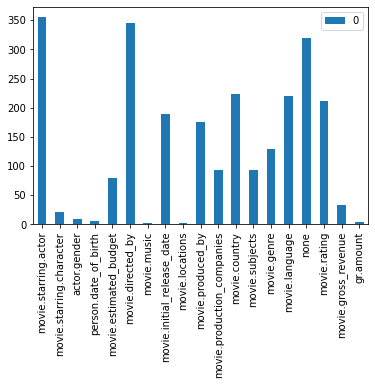

In [ ]:
df = pd.DataFrame.from_dict(label_count, orient='index')
df.plot(kind='bar')

In [ ]:
unique_labels = set(labels_all)
unique_labels

{'actor.gender',
 'gr.amount',
 'movie.country',
 'movie.directed_by',
 'movie.estimated_budget',
 'movie.genre',
 'movie.gross_revenue',
 'movie.initial_release_date',
 'movie.language',
 'movie.locations',
 'movie.music',
 'movie.produced_by',
 'movie.production_companies',
 'movie.rating',
 'movie.starring.actor',
 'movie.starring.character',
 'movie.subjects',
 'none',
 'person.date_of_birth'}

In [ ]:
train

,ID,UTTERANCES,CORE RELATIONS
0,0,who plays luke on star wars new hope,movie.starring.actor movie.starring.character
1,1,show credits for the godfather,movie.starring.actor
2,2,who was the main actor in the exorcist,movie.starring.actor
3,3,find the female actress from the movie she's t...,movie.starring.actor actor.gender
4,4,who played dory on finding nemo,movie.starring.actor movie.starring.character
...,...,...,...
2307,2307,what was the revenue for toy story 3,movie.gross_revenue
2308,2308,dark knight revenue,movie.gross_revenue
2309,2309,how much did the dark night generate,movie.gross_revenue
2310,2310,can i see the lion king's revenue,movie.gross_revenue


In [ ]:
train['processed_core_relations'] = train['CORE RELATIONS'].str.split(' ')
train

,ID,UTTERANCES,CORE RELATIONS,processed_core_relations
0,0,who plays luke on star wars new hope,movie.starring.actor movie.starring.character,"[movie.starring.actor, movie.starring.character]"
1,1,show credits for the godfather,movie.starring.actor,[movie.starring.actor]
2,2,who was the main actor in the exorcist,movie.starring.actor,[movie.starring.actor]
3,3,find the female actress from the movie she's t...,movie.starring.actor actor.gender,"[movie.starring.actor, actor.gender]"
4,4,who played dory on finding nemo,movie.starring.actor movie.starring.character,"[movie.starring.actor, movie.starring.character]"
...,...,...,...,...
2307,2307,what was the revenue for toy story 3,movie.gross_revenue,[movie.gross_revenue]
2308,2308,dark knight revenue,movie.gross_revenue,[movie.gross_revenue]
2309,2309,how much did the dark night generate,movie.gross_revenue,[movie.gross_revenue]
2310,2310,can i see the lion king's revenue,movie.gross_revenue,[movie.gross_revenue]


In [ ]:
train['processed_core_relations']

0       [movie.starring.actor, movie.starring.character]
1                                 [movie.starring.actor]
2                                 [movie.starring.actor]
3                   [movie.starring.actor, actor.gender]
4       [movie.starring.actor, movie.starring.character]
                              ...                       
2307                               [movie.gross_revenue]
2308                               [movie.gross_revenue]
2309                               [movie.gross_revenue]
2310                               [movie.gross_revenue]
2311                               [movie.gross_revenue]
Name: processed_core_relations, Length: 2312, dtype: object

### **Observation Processing**

In [ ]:
train['word_count'] = train['UTTERANCES'].str.count(' ') + 1
train

,ID,UTTERANCES,CORE RELATIONS,processed_core_relations,word_count
0,0,who plays luke on star wars new hope,movie.starring.actor movie.starring.character,"[movie.starring.actor, movie.starring.character]",8
1,1,show credits for the godfather,movie.starring.actor,[movie.starring.actor],5
2,2,who was the main actor in the exorcist,movie.starring.actor,[movie.starring.actor],8
3,3,find the female actress from the movie she's t...,movie.starring.actor actor.gender,"[movie.starring.actor, actor.gender]",10
4,4,who played dory on finding nemo,movie.starring.actor movie.starring.character,"[movie.starring.actor, movie.starring.character]",6
...,...,...,...,...,...
2307,2307,what was the revenue for toy story 3,movie.gross_revenue,[movie.gross_revenue],8
2308,2308,dark knight revenue,movie.gross_revenue,[movie.gross_revenue],3
2309,2309,how much did the dark night generate,movie.gross_revenue,[movie.gross_revenue],7
2310,2310,can i see the lion king's revenue,movie.gross_revenue,[movie.gross_revenue],7


In [ ]:
train['word_count'].describe()

count    2312.000000
mean        6.276384
std         2.589998
min         1.000000
25%         4.000000
50%         6.000000
75%         8.000000
max        21.000000
Name: word_count, dtype: float64

In [ ]:
# Drop rows with word count less than 3 and greater than 15

train = train[(train['word_count'] > 2) & (train['word_count'] < 15)]
train.shape

(2235, 5)

In [ ]:
# strip extra spaces
train['processed_text'] = train.UTTERANCES.str.strip()
#lower case data
train['processed_text'] = train.processed_text.str.lower()

# Remove stopwords
train['processed_text'] = train['processed_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(w, 'v') for w in w_tokenizer.tokenize(text)])


train['processed_text'] = train.processed_text.apply(lemmatize_text)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [ ]:
train

,ID,UTTERANCES,CORE RELATIONS,processed_core_relations,word_count,processed_text
0,0,who plays luke on star wars new hope,movie.starring.actor movie.starring.character,"[movie.starring.actor, movie.starring.character]",8,play luke star war new hope
1,1,show credits for the godfather,movie.starring.actor,[movie.starring.actor],5,show credit godfather
2,2,who was the main actor in the exorcist,movie.starring.actor,[movie.starring.actor],8,main actor exorcist
3,3,find the female actress from the movie she's t...,movie.starring.actor actor.gender,"[movie.starring.actor, actor.gender]",10,find female actress movie man
4,4,who played dory on finding nemo,movie.starring.actor movie.starring.character,"[movie.starring.actor, movie.starring.character]",6,play dory find nemo
...,...,...,...,...,...,...
2307,2307,what was the revenue for toy story 3,movie.gross_revenue,[movie.gross_revenue],8,revenue toy story 3
2308,2308,dark knight revenue,movie.gross_revenue,[movie.gross_revenue],3,dark knight revenue
2309,2309,how much did the dark night generate,movie.gross_revenue,[movie.gross_revenue],7,much dark night generate
2310,2310,can i see the lion king's revenue,movie.gross_revenue,[movie.gross_revenue],7,see lion king's revenue


### **Create Train and Validation sets**

In [ ]:
# Create train, validation and test sets

x_train, x_val, y_train, y_val = train_test_split(train['processed_text'], train['processed_core_relations'], test_size=.2, random_state=42)
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

(1788,) (447,) (1788,) (447,)


### **Encode Data**

In [ ]:
# Encode Observations

vectorizer = TfidfVectorizer()

x_train_transformed = vectorizer.fit_transform(x_train)
x_val_transformed = vectorizer.transform(x_val)
print(x_train_transformed.shape,x_val_transformed.shape )

(1788, 889) (447, 889)


In [ ]:
# Save tfidfvectorizer object

with open('vectorizer.pk', 'wb') as op:
    pickle.dump(vectorizer, op)

In [ ]:
# Encode Labels

binarizer = MultiLabelBinarizer()

binarizer.fit([list(unique_labels)])

y_train_transformed = binarizer.transform(y_train.tolist())
y_val_transformed = binarizer.transform(y_val.tolist())

print(y_train_transformed.shape, y_val_transformed.shape)

(1788, 19) (447, 19)


In [ ]:
# Save Multi-label binarizer object

output = open('binarizer.pkl', 'wb')
pickle.dump(binarizer, output)
output.close()

In [ ]:
# tfidf matrix to pytorch tensor

x_train = torch.tensor(scipy.sparse.csr_matrix.todense(x_train_transformed)).float()
x_val = torch.tensor(scipy.sparse.csr_matrix.todense(x_val_transformed)).float()

In [ ]:
# Multi-hot vector to pytorch tensor

y_train = torch.tensor(y_train_transformed)
y_val = torch.tensor(y_val_transformed)

### **Model setup**

In [ ]:
vocab = len(vectorizer.vocabulary_)
vocab

889

In [ ]:
from torch import nn

model = nn.Sequential(
             nn.Linear(vocab, 512),
             nn.ReLU(),
             nn.Linear(512, 19))


# Define the loss
criterion = nn.BCEWithLogitsLoss()

# Forward pass, log  
logps = model(x_train)

# Calculate the loss with the logits and the labels
loss = criterion(logps, y_train.float())
loss.backward()

# Optimizers need parameters to optimize and a learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=0.12)

In [ ]:
def scoring_fn(labels, predictions):
    for i in range(len(predictions)):
        acc_score = accuracy_score(labels, predictions)
        f1 = f1_score(labels, predictions, average='macro', zero_division=0)
        return acc_score, f1


In [ ]:
epochs = 600
batch_size = 8
threshold = 0.14

avg_train_loss = []
avg_val_loss = []
validation_accuracy = []
validation_f1 = []

patience = 0
best_loss = 0

for e in range(epochs):
    print('Epoch: ',e)
    model.train()
    epoch_train_loss = []
    for i in range(0, len(x_train), batch_size):
        optimizer.zero_grad()
        output = model(x_train[i:i+batch_size])
        loss = criterion(output, y_train[i:i+batch_size].float())
        loss.backward()
        optimizer.step()
        epoch_train_loss.append(loss.item())
    avg_train_loss.append(sum(epoch_train_loss)/len(epoch_train_loss))

    epoch_val_loss = []
    epoch_val_pred = []
    epoch_val_sig = []

    model.eval()
    for i in range(0, len(x_val), batch_size):
        output_val = model(x_val[i:i+batch_size])
        proc_val = torch.tensor(output_val)
        pred = torch.sigmoid(proc_val)
        epoch_val_sig.extend(pred.tolist())
        pred = (pred>threshold).int()
        epoch_val_pred.extend(pred.tolist())
        val_loss = criterion(output_val, y_val[i:i+batch_size].float())
        epoch_val_loss.append(val_loss.item())
    
    avg_val_loss.append(sum(epoch_val_loss)/len(epoch_val_loss))
    
    print('Train_loss: ', sum(epoch_train_loss)/len(epoch_train_loss))
    print('Valid_loss: ', sum(epoch_val_loss)/len(epoch_val_loss))

    # get accuracy and f1
    acc, f1 = scoring_fn(y_val,epoch_val_pred)
    validation_accuracy.append(acc)
    validation_f1.append(f1)

    print('Validation accuracy', acc)
    print('Validation f1', f1)
    

Epoch:  0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.4993070642064725
Valid_loss:  0.29385983145662714
Validation accuracy 0.0
Validation f1 0.10241244496418038
Epoch:  1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.22910079712580358
Valid_loss:  0.20175183883735112
Validation accuracy 0.006711409395973154
Validation f1 0.027166183174471614
Epoch:  2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.1994322564985071
Valid_loss:  0.19468898086675576
Validation accuracy 0.006711409395973154
Validation f1 0.027224521792100023
Epoch:  3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.19561647297814488
Valid_loss:  0.19260313282055513
Validation accuracy 0.0022371364653243847
Validation f1 0.026798069908851422
Epoch:  4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.19417659685547864
Valid_loss:  0.19154317011790617
Validation accuracy 0.0022371364653243847
Validation f1 0.026743086598079172
Epoch:  5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.19338095487494553
Valid_loss:  0.19085605682006904
Validation accuracy 0.0022371364653243847
Validation f1 0.02671575477789878
Epoch:  6


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.1928413734505219
Valid_loss:  0.19034249441964285
Validation accuracy 0.0022371364653243847
Validation f1 0.02671575477789878
Epoch:  7


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.1924215913085001
Valid_loss:  0.1899188147591693
Validation accuracy 0.0022371364653243847
Validation f1 0.02671575477789878
Epoch:  8


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.19206119009426662
Valid_loss:  0.18954374215432576
Validation accuracy 0.0022371364653243847
Validation f1 0.02671575477789878
Epoch:  9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.19172930870471255
Valid_loss:  0.1891936313893114
Validation accuracy 0.0022371364653243847
Validation f1 0.02671575477789878
Epoch:  10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.19140807891796743
Valid_loss:  0.18885429176901067
Validation accuracy 0.0022371364653243847
Validation f1 0.026743086598079172
Epoch:  11


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.19108672652925765
Valid_loss:  0.18851615036172525
Validation accuracy 0.0022371364653243847
Validation f1 0.026798069908851422
Epoch:  12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.19075746667970503
Valid_loss:  0.1881712345140321
Validation accuracy 0.0022371364653243847
Validation f1 0.026798069908851422
Epoch:  13


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.19041398021259479
Valid_loss:  0.18781324050256185
Validation accuracy 0.0022371364653243847
Validation f1 0.0285821912291012
Epoch:  14


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.19005131967631833
Valid_loss:  0.18743673685405934
Validation accuracy 0.0022371364653243847
Validation f1 0.03205823007088333
Epoch:  15


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.18966526598004357
Valid_loss:  0.1870375874319247
Validation accuracy 0.0022371364653243847
Validation f1 0.03620372129925096
Epoch:  16


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.18925180745178036
Valid_loss:  0.18661147595516273
Validation accuracy 0.0022371364653243847
Validation f1 0.04249054512055056
Epoch:  17


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.18880682538396545
Valid_loss:  0.1861546545156411
Validation accuracy 0.0022371364653243847
Validation f1 0.04770526815185902
Epoch:  18


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.18832718494481274
Valid_loss:  0.18566394623901164
Validation accuracy 0.008948545861297539
Validation f1 0.05924865704923434
Epoch:  19


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.1878090805507132
Valid_loss:  0.1851354486175946
Validation accuracy 0.02237136465324385
Validation f1 0.0704947688003339
Epoch:  20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.1872486540648554
Valid_loss:  0.1845653158213411
Validation accuracy 0.02237136465324385
Validation f1 0.08377286934392697
Epoch:  21


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.1866422314196825
Valid_loss:  0.1839498087231602
Validation accuracy 0.029082774049217
Validation f1 0.08751985942181646
Epoch:  22


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.18598640663549304
Valid_loss:  0.18328522065920488
Validation accuracy 0.040268456375838924
Validation f1 0.09241552143425757
Epoch:  23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.18527754482680134
Valid_loss:  0.18256871162780694
Validation accuracy 0.0447427293064877
Validation f1 0.09952777234277944
Epoch:  24


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.18451258280713642
Valid_loss:  0.1817971204540559
Validation accuracy 0.049217002237136466
Validation f1 0.10328055821580341
Epoch:  25


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.1836889282401119
Valid_loss:  0.18096758611500263
Validation accuracy 0.06040268456375839
Validation f1 0.10778044083317954
Epoch:  26


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.182803863526455
Valid_loss:  0.18007644904511316
Validation accuracy 0.06487695749440715
Validation f1 0.10724093118162131
Epoch:  27


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.18185482207419618
Valid_loss:  0.17912202248615877
Validation accuracy 0.07158836689038031
Validation f1 0.11049834573021529
Epoch:  28


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.1808404302490609
Valid_loss:  0.1781031404222761
Validation accuracy 0.08053691275167785
Validation f1 0.11180267023603183
Epoch:  29


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.17975998257419892
Valid_loss:  0.17701874380665167
Validation accuracy 0.10514541387024609
Validation f1 0.11616291091333635
Epoch:  30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.17861281621402927
Valid_loss:  0.17586840742400714
Validation accuracy 0.12080536912751678
Validation f1 0.12165980473682604
Epoch:  31


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.17739941379321472
Valid_loss:  0.17465295349912985
Validation accuracy 0.1319910514541387
Validation f1 0.13163289229174896
Epoch:  32


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.17612121467079436
Valid_loss:  0.17337353846856526
Validation accuracy 0.1342281879194631
Validation f1 0.14046088075121613
Epoch:  33


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.17478008934163622
Valid_loss:  0.17203195712396077
Validation accuracy 0.13870246085011187
Validation f1 0.14346357396522305
Epoch:  34


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.17337818324033702
Valid_loss:  0.17063107607620104
Validation accuracy 0.14988814317673377
Validation f1 0.15530104714073073
Epoch:  35


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.17191888551626885
Valid_loss:  0.16917435798261846
Validation accuracy 0.15883668903803133
Validation f1 0.1615724628627788
Epoch:  36


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.1704047971538135
Valid_loss:  0.16766381237123693
Validation accuracy 0.1610738255033557
Validation f1 0.17326131119592478
Epoch:  37


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.16883858905306884
Valid_loss:  0.16610299343509333
Validation accuracy 0.1767337807606264
Validation f1 0.18130316747026756
Epoch:  38


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.16722323941732092
Valid_loss:  0.16449538139360292
Validation accuracy 0.19463087248322147
Validation f1 0.18610157616280934
Epoch:  39


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.16556183428370527
Valid_loss:  0.16284374307308877
Validation accuracy 0.203579418344519
Validation f1 0.19870193055695914
Epoch:  40


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.16385697846167854
Valid_loss:  0.16115244132067477
Validation accuracy 0.21252796420581654
Validation f1 0.21214129172892948
Epoch:  41


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.16211132362617978
Valid_loss:  0.1594244587634291
Validation accuracy 0.23042505592841164
Validation f1 0.23046968273424698
Epoch:  42


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.16032773658766278
Valid_loss:  0.15766384053443158
Validation accuracy 0.2483221476510067
Validation f1 0.24188125909101574
Epoch:  43


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.1585092657977449
Valid_loss:  0.15587462564664228
Validation accuracy 0.25279642058165547
Validation f1 0.25237217236733944
Epoch:  44


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.15665927336418203
Valid_loss:  0.15406161320528813
Validation accuracy 0.25727069351230425
Validation f1 0.26178620792082113
Epoch:  45


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.15478168866996253
Valid_loss:  0.1522300194150635
Validation accuracy 0.2662192393736018
Validation f1 0.2652392296310442
Epoch:  46


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.15288126708141395
Valid_loss:  0.15038390856768405
Validation accuracy 0.2796420581655481
Validation f1 0.2741743838622184
Epoch:  47


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.15096250143168227
Valid_loss:  0.14852855753685748
Validation accuracy 0.29082774049217003
Validation f1 0.279495524923857
Epoch:  48


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.14903032962631965
Valid_loss:  0.14666925077991827
Validation accuracy 0.3042505592841163
Validation f1 0.2831115034251066
Epoch:  49


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.1470895519014448
Valid_loss:  0.14481147511729173
Validation accuracy 0.3131991051454139
Validation f1 0.2837397311956493
Epoch:  50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.1451455904503486
Valid_loss:  0.14296011786375726
Validation accuracy 0.3221476510067114
Validation f1 0.2850861185052044
Epoch:  51


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.14320372211347734
Valid_loss:  0.1411202581865447
Validation accuracy 0.33557046979865773
Validation f1 0.28492214344292216
Epoch:  52


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.1412688140823905
Valid_loss:  0.13929605084870542
Validation accuracy 0.3378076062639821
Validation f1 0.2858514482665287
Epoch:  53


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.13934559165500104
Valid_loss:  0.1374923669333969
Validation accuracy 0.3422818791946309
Validation f1 0.2870793133665057
Epoch:  54


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.1374388541693666
Valid_loss:  0.13571304415485688
Validation accuracy 0.3422818791946309
Validation f1 0.2865921097384958
Epoch:  55


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.1355530222478722
Valid_loss:  0.13396160104977234
Validation accuracy 0.34451901565995524
Validation f1 0.28539064297488165
Epoch:  56


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.13369212056776242
Valid_loss:  0.13224155362695456
Validation accuracy 0.34451901565995524
Validation f1 0.2852549024033384
Epoch:  57


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.13185978082141706
Valid_loss:  0.1305562245792576
Validation accuracy 0.3534675615212528
Validation f1 0.2863630693247785
Epoch:  58


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.13005916860752872
Valid_loss:  0.12890765736145632
Validation accuracy 0.3579418344519016
Validation f1 0.2867603465206645
Epoch:  59


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.12829263731172041
Valid_loss:  0.12729778486703122
Validation accuracy 0.36465324384787473
Validation f1 0.28856436422237036
Epoch:  60


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.12656239167387998
Valid_loss:  0.12572842171149595
Validation accuracy 0.3691275167785235
Validation f1 0.2900449226537478
Epoch:  61


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.12487024541145988
Valid_loss:  0.12420014704444579
Validation accuracy 0.37583892617449666
Validation f1 0.29068786621066095
Epoch:  62


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.12321731298496681
Valid_loss:  0.12271444552711078
Validation accuracy 0.378076062639821
Validation f1 0.29246815579143515
Epoch:  63


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.12160442124253937
Valid_loss:  0.12127083340393645
Validation accuracy 0.3825503355704698
Validation f1 0.29334503567579395
Epoch:  64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.12003204203210771
Valid_loss:  0.11986933941287654
Validation accuracy 0.39149888143176736
Validation f1 0.29380589012212927
Epoch:  65


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.11850020874823843
Valid_loss:  0.1185096963973982
Validation accuracy 0.39149888143176736
Validation f1 0.29470392094019265
Epoch:  66


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.11700864643457212
Valid_loss:  0.11719068485711302
Validation accuracy 0.3959731543624161
Validation f1 0.2962266483465112
Epoch:  67


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.11555666637806487
Valid_loss:  0.11591169437659639
Validation accuracy 0.3982102908277405
Validation f1 0.2989524823745892
Epoch:  68


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.11414358177821018
Valid_loss:  0.11467166391334363
Validation accuracy 0.42058165548098436
Validation f1 0.3069919469642573
Epoch:  69


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.112768305399056
Valid_loss:  0.11346928123384714
Validation accuracy 0.4228187919463087
Validation f1 0.30772082010213425
Epoch:  70


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.1114297442005149
Valid_loss:  0.1123027592631323
Validation accuracy 0.4272930648769575
Validation f1 0.30777089501944366
Epoch:  71


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.11012651111065809
Valid_loss:  0.11117054708302021
Validation accuracy 0.42953020134228187
Validation f1 0.3092915399240151
Epoch:  72


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.1088569096090006
Valid_loss:  0.1100711774613176
Validation accuracy 0.42953020134228187
Validation f1 0.30967099534991016
Epoch:  73


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.10761962759508086
Valid_loss:  0.10900334707860436
Validation accuracy 0.43400447427293065
Validation f1 0.3112533472271776
Epoch:  74


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.10641318797466479
Valid_loss:  0.10796498813267265
Validation accuracy 0.4407158836689038
Validation f1 0.31585166949129373
Epoch:  75


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.10523595098805215
Valid_loss:  0.10695460917694229
Validation accuracy 0.4451901565995526
Validation f1 0.32531207470968837
Epoch:  76


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.10408641693980566
Valid_loss:  0.1059705141399588
Validation accuracy 0.44966442953020136
Validation f1 0.3288322829437178
Epoch:  77


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.10296306205314718
Valid_loss:  0.1050110472632306
Validation accuracy 0.4608501118568233
Validation f1 0.333447638016296
Epoch:  78


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.10186421345653278
Valid_loss:  0.10407500221793141
Validation accuracy 0.46756152125279643
Validation f1 0.34054338708322995
Epoch:  79


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.10078855838427055
Valid_loss:  0.10316112331513848
Validation accuracy 0.4720357941834452
Validation f1 0.3457005326170384
Epoch:  80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.0997348110956539
Valid_loss:  0.10226832010916301
Validation accuracy 0.4809843400447427
Validation f1 0.35080912986277896
Epoch:  81


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.09870170944902514
Valid_loss:  0.10139511059969664
Validation accuracy 0.4854586129753915
Validation f1 0.36787047145475466
Epoch:  82


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.0976880801608786
Valid_loss:  0.10054022146921072
Validation accuracy 0.49217002237136465
Validation f1 0.37627177775079784
Epoch:  83


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.0966926217744393
Valid_loss:  0.09970282909593411
Validation accuracy 0.4966442953020134
Validation f1 0.385863939974539
Epoch:  84


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.09571433541298445
Valid_loss:  0.0988817826977798
Validation accuracy 0.4988814317673378
Validation f1 0.3878291100214388
Epoch:  85


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.09475232702347317
Valid_loss:  0.09807601890393666
Validation accuracy 0.5055928411633109
Validation f1 0.3930677019375883
Epoch:  86


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.09380570710969291
Valid_loss:  0.09728440928405949
Validation accuracy 0.5123042505592841
Validation f1 0.40521023413556007
Epoch:  87


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.09287327960399645
Valid_loss:  0.09650691651872226
Validation accuracy 0.5123042505592841
Validation f1 0.407978802823678
Epoch:  88


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.0919548445880147
Valid_loss:  0.09574253677523561
Validation accuracy 0.5100671140939598
Validation f1 0.41638346873013005
Epoch:  89


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.09104930983656752
Valid_loss:  0.09499084457222905
Validation accuracy 0.5123042505592841
Validation f1 0.4197419269713065
Epoch:  90


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.09015615129776831
Valid_loss:  0.0942510547382491
Validation accuracy 0.5167785234899329
Validation f1 0.4203034499703055
Epoch:  91


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.08927483841710325
Valid_loss:  0.09352271418486323
Validation accuracy 0.5212527964205816
Validation f1 0.4270577463615151
Epoch:  92


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.08840490061057997
Valid_loss:  0.09280515269243292
Validation accuracy 0.5302013422818792
Validation f1 0.43495286878504713
Epoch:  93


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.0875457967964134
Valid_loss:  0.09209847250687224
Validation accuracy 0.5302013422818792
Validation f1 0.4353717692673592
Epoch:  94


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.08669725883685585
Valid_loss:  0.09140237680237208
Validation accuracy 0.5302013422818792
Validation f1 0.43491587428016704
Epoch:  95


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.08585903189876783
Valid_loss:  0.0907171958658312
Validation accuracy 0.5369127516778524
Validation f1 0.43716148428200974
Epoch:  96


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.08503087337261864
Valid_loss:  0.09004139354718584
Validation accuracy 0.5413870246085011
Validation f1 0.43980975357632607
Epoch:  97


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.08421248205870922
Valid_loss:  0.08937531430274248
Validation accuracy 0.5413870246085011
Validation f1 0.4386406515768868
Epoch:  98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.08340362190002841
Valid_loss:  0.08871896964098726
Validation accuracy 0.5436241610738255
Validation f1 0.43821935375934334
Epoch:  99


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.08260391530347988
Valid_loss:  0.08807183715647884
Validation accuracy 0.5436241610738255
Validation f1 0.4407336946203852
Epoch:  100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.08181332237186975
Valid_loss:  0.08743390214762517
Validation accuracy 0.5436241610738255
Validation f1 0.4422616758822852
Epoch:  101


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.0810317630530335
Valid_loss:  0.08680522348731756
Validation accuracy 0.5436241610738255
Validation f1 0.4422616758822852
Epoch:  102


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.0802589924174494
Valid_loss:  0.08618546164195452
Validation accuracy 0.5436241610738255
Validation f1 0.4422616758822852
Epoch:  103


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.07949503565240386
Valid_loss:  0.08557458048952478
Validation accuracy 0.5436241610738255
Validation f1 0.44432148126619037
Epoch:  104


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.07873949778565605
Valid_loss:  0.08497273143646973
Validation accuracy 0.5436241610738255
Validation f1 0.4424120061104718
Epoch:  105


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.0779924594514471
Valid_loss:  0.08437893725931644
Validation accuracy 0.5436241610738255
Validation f1 0.44110806246202744
Epoch:  106


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.07725385583138891
Valid_loss:  0.08379400215510811
Validation accuracy 0.5480984340044742
Validation f1 0.4417444755413736
Epoch:  107


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.07652367267291993
Valid_loss:  0.08321782507534538
Validation accuracy 0.5548098434004475
Validation f1 0.44401632958508835
Epoch:  108


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.07580168929416686
Valid_loss:  0.08265003701671958
Validation accuracy 0.5503355704697986
Validation f1 0.4445158372701292
Epoch:  109


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.07508783858169668
Valid_loss:  0.08209092855187398
Validation accuracy 0.5570469798657718
Validation f1 0.4495816805029905
Epoch:  110


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.07438219978939742
Valid_loss:  0.08153934284512486
Validation accuracy 0.5525727069351231
Validation f1 0.44908675791185787
Epoch:  111


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.07368452587564077
Valid_loss:  0.08099623117595911
Validation accuracy 0.5548098434004475
Validation f1 0.4499827143805698
Epoch:  112


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.07299487328522705
Valid_loss:  0.08046090130561165
Validation accuracy 0.5548098434004475
Validation f1 0.4502407123165863
Epoch:  113


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.0723132891331001
Valid_loss:  0.07993370287918619
Validation accuracy 0.5592841163310962
Validation f1 0.4553690956407103
Epoch:  114


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.07163933630467259
Valid_loss:  0.07941432436928153
Validation accuracy 0.5659955257270693
Validation f1 0.45842820765635983
Epoch:  115


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.07097314456976685
Valid_loss:  0.07890326416652117
Validation accuracy 0.5659955257270693
Validation f1 0.4611195952161684
Epoch:  116


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.07031486336407917
Valid_loss:  0.078400129851486
Validation accuracy 0.5659955257270693
Validation f1 0.46255827317171994
Epoch:  117


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.06966422589695347
Valid_loss:  0.07790443700339113
Validation accuracy 0.5659955257270693
Validation f1 0.46255827317171994
Epoch:  118


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.06902131834067404
Valid_loss:  0.07741607306525111
Validation accuracy 0.5727069351230425
Validation f1 0.4636909170805719
Epoch:  119


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.06838596057579187
Valid_loss:  0.07693553463156734
Validation accuracy 0.5749440715883669
Validation f1 0.46395937345641086
Epoch:  120


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.06775815813203476
Valid_loss:  0.07646255108660885
Validation accuracy 0.5816554809843401
Validation f1 0.46660010374486877
Epoch:  121


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.06713794012154851
Valid_loss:  0.07599663847525205
Validation accuracy 0.5838926174496645
Validation f1 0.4670387002360968
Epoch:  122


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.06652486880609233
Valid_loss:  0.07553777783843023
Validation accuracy 0.5950782997762863
Validation f1 0.47144112744215805
Epoch:  123


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.06591899874287524
Valid_loss:  0.07508591954995479
Validation accuracy 0.5995525727069351
Validation f1 0.47528292222099633
Epoch:  124


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.0653205237550927
Valid_loss:  0.0746415480306106
Validation accuracy 0.5995525727069351
Validation f1 0.47528292222099633
Epoch:  125


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.06472918639857587
Valid_loss:  0.07420372553834957
Validation accuracy 0.5995525727069351
Validation f1 0.47528292222099633
Epoch:  126


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.06414501808051552
Valid_loss:  0.07377288354161594
Validation accuracy 0.5995525727069351
Validation f1 0.4756281589727801
Epoch:  127


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.06356790128795962
Valid_loss:  0.07334874946224902
Validation accuracy 0.5995525727069351
Validation f1 0.4756281589727801
Epoch:  128


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.0629975567072896
Valid_loss:  0.07293120435705143
Validation accuracy 0.6017897091722595
Validation f1 0.47989324124117555
Epoch:  129


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.06243414308742753
Valid_loss:  0.07251989422366023
Validation accuracy 0.6040268456375839
Validation f1 0.47961695987155445
Epoch:  130


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.061877641710452735
Valid_loss:  0.07211424323863216
Validation accuracy 0.6085011185682326
Validation f1 0.48187896499901806
Epoch:  131


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.061327591039506454
Valid_loss:  0.0717155043634453
Validation accuracy 0.6129753914988815
Validation f1 0.48245167076845324
Epoch:  132


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.06078422718149211
Valid_loss:  0.07132206281780132
Validation accuracy 0.6174496644295302
Validation f1 0.4814512622335981
Epoch:  133


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.0602470912521572
Valid_loss:  0.07093482331505843
Validation accuracy 0.6196868008948546
Validation f1 0.48224978895882037
Epoch:  134


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.05971653967364026
Valid_loss:  0.07055314324264016
Validation accuracy 0.6152125279642058
Validation f1 0.4810705826316873
Epoch:  135


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.05919220371704016
Valid_loss:  0.07017770236624139
Validation accuracy 0.6152125279642058
Validation f1 0.4810705826316873
Epoch:  136


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.0586742751017612
Valid_loss:  0.06980742005232189
Validation accuracy 0.6152125279642058
Validation f1 0.4810705826316873
Epoch:  137


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.058162582647388
Valid_loss:  0.06944309135100671
Validation accuracy 0.6152125279642058
Validation f1 0.4810705826316873
Epoch:  138


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.05765694894528549
Valid_loss:  0.06908453225956432
Validation accuracy 0.6152125279642058
Validation f1 0.48354108841020194
Epoch:  139


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.057157325716356615
Valid_loss:  0.0687308982014656
Validation accuracy 0.6174496644295302
Validation f1 0.4842528510382486
Epoch:  140


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.05666379374451935
Valid_loss:  0.06838307383337192
Validation accuracy 0.6174496644295302
Validation f1 0.4845561117700575
Epoch:  141


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.056176195902350755
Valid_loss:  0.06804030411876738
Validation accuracy 0.6174496644295302
Validation f1 0.48395717488303186
Epoch:  142


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.05569454353202933
Valid_loss:  0.06770274226021554
Validation accuracy 0.6174496644295302
Validation f1 0.4836840087462133
Epoch:  143


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.05521849875471422
Valid_loss:  0.06737037817947567
Validation accuracy 0.6196868008948546
Validation f1 0.4831408483524196
Epoch:  144


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.05474835093731859
Valid_loss:  0.06704269722104073
Validation accuracy 0.6219239373601789
Validation f1 0.4831405739232008
Epoch:  145


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.054283880171299516
Valid_loss:  0.06671959501025933
Validation accuracy 0.6196868008948546
Validation f1 0.4825964798838754
Epoch:  146


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.05382485114803005
Valid_loss:  0.06640179604957146
Validation accuracy 0.6219239373601789
Validation f1 0.485722871714846
Epoch:  147


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.05337169836691048
Valid_loss:  0.06608861608297698
Validation accuracy 0.6263982102908278
Validation f1 0.48576397147530487
Epoch:  148


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.052923806656118746
Valid_loss:  0.06578001216985285
Validation accuracy 0.6263982102908278
Validation f1 0.48576397147530487
Epoch:  149


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.0524815070675686
Valid_loss:  0.06547593980628465
Validation accuracy 0.6286353467561522
Validation f1 0.4860408290464047
Epoch:  150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.052044804099880694
Valid_loss:  0.06517637540985431
Validation accuracy 0.6286353467561522
Validation f1 0.4876328620181881
Epoch:  151


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.05161333169339092
Valid_loss:  0.06488171808554657
Validation accuracy 0.6308724832214765
Validation f1 0.487903789920695
Epoch:  152


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.05118727802515163
Valid_loss:  0.06459118339366146
Validation accuracy 0.6308724832214765
Validation f1 0.4887756986080761
Epoch:  153


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.05076633661103967
Valid_loss:  0.06430506110856575
Validation accuracy 0.6286353467561522
Validation f1 0.48824874018638087
Epoch:  154


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.05035070178564638
Valid_loss:  0.0640235803023513
Validation accuracy 0.6308724832214765
Validation f1 0.4886966685178478
Epoch:  155


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.049940082909805436
Valid_loss:  0.06374621690650072
Validation accuracy 0.6420581655480985
Validation f1 0.4914062067984838
Epoch:  156


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.049534755309910646
Valid_loss:  0.06347258904549692
Validation accuracy 0.6465324384787472
Validation f1 0.49321888830979654
Epoch:  157


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.04913437586011631
Valid_loss:  0.0632038558833301
Validation accuracy 0.6465324384787472
Validation f1 0.49321888830979654
Epoch:  158


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.04873910204956441
Valid_loss:  0.0629384903835931
Validation accuracy 0.6487695749440716
Validation f1 0.49349752917326783
Epoch:  159


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.048348582694805894
Valid_loss:  0.06267762443582926
Validation accuracy 0.6532438478747203
Validation f1 0.49655023372299606
Epoch:  160


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.04796293116773346
Valid_loss:  0.06242040325222271
Validation accuracy 0.6554809843400448
Validation f1 0.49711414349743216
Epoch:  161


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.04758231760933995
Valid_loss:  0.06216693905714367
Validation accuracy 0.6577181208053692
Validation f1 0.4974025357108424
Epoch:  162


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.047206257336906025
Valid_loss:  0.06191790110564658
Validation accuracy 0.6599552572706935
Validation f1 0.49815120681962427
Epoch:  163


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.046834975019529726
Valid_loss:  0.061672313404934745
Validation accuracy 0.6599552572706935
Validation f1 0.49894147076778295
Epoch:  164


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.04646840997156687
Valid_loss:  0.06143028794654778
Validation accuracy 0.6599552572706935
Validation f1 0.49894147076778295
Epoch:  165


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.046106349394124536
Valid_loss:  0.06119213545961039
Validation accuracy 0.6599552572706935
Validation f1 0.49894147076778295
Epoch:  166


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.04574883378310395
Valid_loss:  0.06095795117185584
Validation accuracy 0.6621923937360179
Validation f1 0.4987144663123465
Epoch:  167


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.04539593341178261
Valid_loss:  0.06072685564868152
Validation accuracy 0.668903803131991
Validation f1 0.5007295327606223
Epoch:  168


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.04504742102913691
Valid_loss:  0.06049916726936187
Validation accuracy 0.668903803131991
Validation f1 0.5007295327606223
Epoch:  169


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.04470325729926117
Valid_loss:  0.06027542975997286
Validation accuracy 0.668903803131991
Validation f1 0.501016220703501
Epoch:  170


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.04436348579474725
Valid_loss:  0.06005497483004417
Validation accuracy 0.668903803131991
Validation f1 0.501016220703501
Epoch:  171


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.044027880732236166
Valid_loss:  0.05983775435015559
Validation accuracy 0.668903803131991
Validation f1 0.501016220703501
Epoch:  172


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.04369645857202288
Valid_loss:  0.059624347336856384
Validation accuracy 0.668903803131991
Validation f1 0.4999121138737051
Epoch:  173


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.0433693232314129
Valid_loss:  0.05941391839379711
Validation accuracy 0.6756152125279642
Validation f1 0.5029082189371227
Epoch:  174


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.04304607592972128
Valid_loss:  0.05920666988406863
Validation accuracy 0.680089485458613
Validation f1 0.5054835049142888
Epoch:  175


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.04272701656529015
Valid_loss:  0.05900298128835857
Validation accuracy 0.6778523489932886
Validation f1 0.5175802791078372
Epoch:  176


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.042412090743060356
Valid_loss:  0.05880176299251616
Validation accuracy 0.6778523489932886
Validation f1 0.5185953826176345
Epoch:  177


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.04210081779248347
Valid_loss:  0.058603531148816855
Validation accuracy 0.6778523489932886
Validation f1 0.5185953826176345
Epoch:  178


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.041793547537443895
Valid_loss:  0.05840874543147428
Validation accuracy 0.6778523489932886
Validation f1 0.5200290743739068
Epoch:  179


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.04149017865087704
Valid_loss:  0.05821653462148139
Validation accuracy 0.6845637583892618
Validation f1 0.5238808295289894
Epoch:  180


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.04119049700758686
Valid_loss:  0.05802733634066369
Validation accuracy 0.6823266219239373
Validation f1 0.5233751039934622
Epoch:  181


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.0408944668098619
Valid_loss:  0.057841663514929156
Validation accuracy 0.6823266219239373
Validation f1 0.5233751039934622
Epoch:  182


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.04060209247316899
Valid_loss:  0.05765847233124077
Validation accuracy 0.6823266219239373
Validation f1 0.5249624055807638
Epoch:  183


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.04031349355188597
Valid_loss:  0.05747787068997111
Validation accuracy 0.6845637583892618
Validation f1 0.5265361072768645
Epoch:  184


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.040028170112886334
Valid_loss:  0.057300040631421974
Validation accuracy 0.6845637583892618
Validation f1 0.5265361072768645
Epoch:  185


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.0397464336710982
Valid_loss:  0.05712494872776525
Validation accuracy 0.6868008948545862
Validation f1 0.525936775420682
Epoch:  186


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.039468170052194704
Valid_loss:  0.056952142322968156
Validation accuracy 0.6868008948545862
Validation f1 0.5264380285535141
Epoch:  187


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.03919322235742584
Valid_loss:  0.05678244500554034
Validation accuracy 0.6868008948545862
Validation f1 0.5264380285535141
Epoch:  188


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.038921484465910386
Valid_loss:  0.05661435205755489
Validation accuracy 0.6868008948545862
Validation f1 0.5264380285535141
Epoch:  189


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.038653300023205314
Valid_loss:  0.05644946462208671
Validation accuracy 0.6868008948545862
Validation f1 0.5264380285535141
Epoch:  190


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.03838813750189729
Valid_loss:  0.05628707356351827
Validation accuracy 0.6868008948545862
Validation f1 0.5264380285535141
Epoch:  191


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.038126193514991816
Valid_loss:  0.05612725082651845
Validation accuracy 0.6868008948545862
Validation f1 0.5264652886625943
Epoch:  192


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.03786738894164695
Valid_loss:  0.05596905422862619
Validation accuracy 0.6868008948545862
Validation f1 0.5266740161332969
Epoch:  193


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.03761161577754787
Valid_loss:  0.055814230997514515
Validation accuracy 0.6890380313199105
Validation f1 0.5269648589738987
Epoch:  194


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.037358839742539986
Valid_loss:  0.05566045001614839
Validation accuracy 0.6912751677852349
Validation f1 0.527259947695385
Epoch:  195


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.03710918959196923
Valid_loss:  0.05550954602326134
Validation accuracy 0.6935123042505593
Validation f1 0.5277276354803822
Epoch:  196


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.03686226480307856
Valid_loss:  0.05536093281781567
Validation accuracy 0.6935123042505593
Validation f1 0.5277276354803822
Epoch:  197


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.036618256060007424
Valid_loss:  0.05521403918308871
Validation accuracy 0.6912751677852349
Validation f1 0.5269545162416073
Epoch:  198


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.036377259147619564
Valid_loss:  0.0550700133400304
Validation accuracy 0.6890380313199105
Validation f1 0.5348492530837126
Epoch:  199


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.036138839475045516
Valid_loss:  0.05492755396491183
Validation accuracy 0.6890380313199105
Validation f1 0.5348492530837126
Epoch:  200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.03590328450497639
Valid_loss:  0.0547870689271284
Validation accuracy 0.6912751677852349
Validation f1 0.5362339133031678
Epoch:  201


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.03567044609891517
Valid_loss:  0.05464884322801871
Validation accuracy 0.6935123042505593
Validation f1 0.5367825985688581
Epoch:  202


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.035440101487828155
Valid_loss:  0.05451204627752304
Validation accuracy 0.6912751677852349
Validation f1 0.5364583188628717
Epoch:  203


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.03521249472812217
Valid_loss:  0.05437812726345977
Validation accuracy 0.6912751677852349
Validation f1 0.5364583188628717
Epoch:  204


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.03498729742464742
Valid_loss:  0.054244905577174256
Validation accuracy 0.6912751677852349
Validation f1 0.5364583188628717
Epoch:  205


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.03476483524095134
Valid_loss:  0.05411424481176904
Validation accuracy 0.6957494407158836
Validation f1 0.5378142122247234
Epoch:  206


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.03454468229652515
Valid_loss:  0.05398590322251299
Validation accuracy 0.6957494407158836
Validation f1 0.5378142122247234
Epoch:  207


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.03432710179393845
Valid_loss:  0.0538581817776763
Validation accuracy 0.6957494407158836
Validation f1 0.5381452284445182
Epoch:  208


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.034111570117862096
Valid_loss:  0.05373365691463862
Validation accuracy 0.697986577181208
Validation f1 0.5384458848777306
Epoch:  209


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.033898817957378924
Valid_loss:  0.05360966090977724
Validation accuracy 0.697986577181208
Validation f1 0.5387496746552046
Epoch:  210


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.03368807421897405
Valid_loss:  0.05348701091549758
Validation accuracy 0.697986577181208
Validation f1 0.5387496746552046
Epoch:  211


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.03347978275685039
Valid_loss:  0.05336724753890719
Validation accuracy 0.697986577181208
Validation f1 0.5387496746552046
Epoch:  212


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.03327375079970807
Valid_loss:  0.053248554950446954
Validation accuracy 0.697986577181208
Validation f1 0.5387496746552046
Epoch:  213


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.033069845738022456
Valid_loss:  0.053131582298582156
Validation accuracy 0.7024608501118568
Validation f1 0.5393794542323526
Epoch:  214


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.032868203482524096
Valid_loss:  0.05301607769381787
Validation accuracy 0.7046979865771812
Validation f1 0.5393921344228819
Epoch:  215


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.032668708923405836
Valid_loss:  0.05290245018633349
Validation accuracy 0.7069351230425056
Validation f1 0.53969992143427
Epoch:  216


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.03247128407903282
Valid_loss:  0.05278943304438144
Validation accuracy 0.70917225950783
Validation f1 0.5399923190950888
Epoch:  217


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.03227600490624484
Valid_loss:  0.05267840866664691
Validation accuracy 0.7114093959731543
Validation f1 0.5403019166183086
Epoch:  218


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.03208258479051957
Valid_loss:  0.052569835047636716
Validation accuracy 0.7136465324384788
Validation f1 0.5414006229801728
Epoch:  219


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.031891382552982704
Valid_loss:  0.052461548059779615
Validation accuracy 0.7181208053691275
Validation f1 0.549400058394018
Epoch:  220


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.0317022210219875
Valid_loss:  0.05235536356589624
Validation accuracy 0.7181208053691275
Validation f1 0.549400058394018
Epoch:  221


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.031514840346062556
Valid_loss:  0.052250855502539446
Validation accuracy 0.7225950782997763
Validation f1 0.5505366207300909
Epoch:  222


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.03132943241923515
Valid_loss:  0.05214625793243093
Validation accuracy 0.7248322147651006
Validation f1 0.5569162060570446
Epoch:  223


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.031145889663353694
Valid_loss:  0.0520447345417259
Validation accuracy 0.727069351230425
Validation f1 0.5755331367332496
Epoch:  224


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.030964317066328868
Valid_loss:  0.05194378714077175
Validation accuracy 0.7293064876957495
Validation f1 0.5865574141246643
Epoch:  225


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.030784767649103224
Valid_loss:  0.05184398468450776
Validation accuracy 0.7293064876957495
Validation f1 0.5865574141246643
Epoch:  226


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.030606643483874256
Valid_loss:  0.05174583342990705
Validation accuracy 0.7293064876957495
Validation f1 0.5865574141246643
Epoch:  227


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.030430689071571187
Valid_loss:  0.051648939294474464
Validation accuracy 0.7293064876957495
Validation f1 0.5865574141246643
Epoch:  228


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.030256293298277472
Valid_loss:  0.05155356728937477
Validation accuracy 0.7293064876957495
Validation f1 0.5874475888214485
Epoch:  229


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.030083888297667727
Valid_loss:  0.051458587570648105
Validation accuracy 0.7293064876957495
Validation f1 0.5874475888214485
Epoch:  230


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.029912887328204567
Valid_loss:  0.05136553357754435
Validation accuracy 0.7315436241610739
Validation f1 0.5878197312988543
Epoch:  231


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.029743974352771017
Valid_loss:  0.05127378017641604
Validation accuracy 0.7315436241610739
Validation f1 0.5885002204003961
Epoch:  232


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.029576268737270896
Valid_loss:  0.05118256330024451
Validation accuracy 0.7315436241610739
Validation f1 0.5893831653222016
Epoch:  233


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.029410648533874855
Valid_loss:  0.05109347017215831
Validation accuracy 0.7315436241610739
Validation f1 0.5893831653222016
Epoch:  234


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.029246433621405492
Valid_loss:  0.051005059420796375
Validation accuracy 0.7315436241610739
Validation f1 0.5893831653222016
Epoch:  235


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.02908405397777512
Valid_loss:  0.05091799798953746
Validation accuracy 0.7315436241610739
Validation f1 0.5893831653222016
Epoch:  236


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.028923168666161864
Valid_loss:  0.050832472275942564
Validation accuracy 0.7337807606263982
Validation f1 0.5901562845609765
Epoch:  237


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.02876393257923025
Valid_loss:  0.05074708103867514
Validation accuracy 0.7360178970917226
Validation f1 0.5910888485290362
Epoch:  238


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.028605988313626898
Valid_loss:  0.05066419273082699
Validation accuracy 0.7360178970917226
Validation f1 0.5910888485290362
Epoch:  239


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.028449881709613174
Valid_loss:  0.05058145577952798
Validation accuracy 0.7337807606263982
Validation f1 0.5959799511420556
Epoch:  240


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.028295010517467745
Valid_loss:  0.05050008712402944
Validation accuracy 0.7337807606263982
Validation f1 0.5959799511420556
Epoch:  241


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.028141932865504975
Valid_loss:  0.050420256630916684
Validation accuracy 0.7360178970917226
Validation f1 0.5967797296649262
Epoch:  242


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.027990164297599613
Valid_loss:  0.050340524658427706
Validation accuracy 0.7360178970917226
Validation f1 0.5967797296649262
Epoch:  243


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.027840130725443096
Valid_loss:  0.0502621531985434
Validation accuracy 0.7360178970917226
Validation f1 0.5967797296649262
Epoch:  244


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.027691283737242754
Valid_loss:  0.05018558289988765
Validation accuracy 0.7360178970917226
Validation f1 0.5930203311686855
Epoch:  245


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.027544138279543922
Valid_loss:  0.050109236085388274
Validation accuracy 0.7360178970917226
Validation f1 0.5930203311686855
Epoch:  246


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.027398142601928806
Valid_loss:  0.0500347495877317
Validation accuracy 0.7360178970917226
Validation f1 0.5930203311686855
Epoch:  247


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.027253853747554655
Valid_loss:  0.049961286081400304
Validation accuracy 0.7360178970917226
Validation f1 0.5935260567042128
Epoch:  248


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.02711083168521457
Valid_loss:  0.04988808590652687
Validation accuracy 0.7360178970917226
Validation f1 0.5935260567042128
Epoch:  249


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.026969336438924074
Valid_loss:  0.0498165283185829
Validation accuracy 0.7360178970917226
Validation f1 0.5935260567042128
Epoch:  250


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.026829006183626398
Valid_loss:  0.04974530745364193
Validation accuracy 0.7360178970917226
Validation f1 0.5935260567042128
Epoch:  251


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.026689920886253406
Valid_loss:  0.049676334452150125
Validation accuracy 0.738255033557047
Validation f1 0.5941930707740408
Epoch:  252


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.026552617429323227
Valid_loss:  0.049607031662682335
Validation accuracy 0.738255033557047
Validation f1 0.5941930707740408
Epoch:  253


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.026416132478126592
Valid_loss:  0.04953954365503575
Validation accuracy 0.738255033557047
Validation f1 0.594842210663687
Epoch:  254


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.02628128055117226
Valid_loss:  0.04947300972084382
Validation accuracy 0.738255033557047
Validation f1 0.5956928220406142
Epoch:  255


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.02614754976821132
Valid_loss:  0.04940645469884787
Validation accuracy 0.7404921700223713
Validation f1 0.597921175181531
Epoch:  256


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.026014996218561594
Valid_loss:  0.049341935431584716
Validation accuracy 0.7404921700223713
Validation f1 0.597921175181531
Epoch:  257


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.025884013918195187
Valid_loss:  0.04927775265449392
Validation accuracy 0.7404921700223713
Validation f1 0.597921175181531
Epoch:  258


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.025754216237276393
Valid_loss:  0.04921484444223877
Validation accuracy 0.7404921700223713
Validation f1 0.597921175181531
Epoch:  259


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.02562537822190539
Valid_loss:  0.049153179894866686
Validation accuracy 0.7404921700223713
Validation f1 0.597921175181531
Epoch:  260


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.025498163630670336
Valid_loss:  0.04909103107638657
Validation accuracy 0.7404921700223713
Validation f1 0.597921175181531
Epoch:  261


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.025371762381317758
Valid_loss:  0.04903135576751083
Validation accuracy 0.7404921700223713
Validation f1 0.597921175181531
Epoch:  262


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.025246890047648258
Valid_loss:  0.04897173731920442
Validation accuracy 0.7449664429530202
Validation f1 0.6021422541948538
Epoch:  263


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.02512291922175791
Valid_loss:  0.04891261596432222
Validation accuracy 0.7449664429530202
Validation f1 0.6021422541948538
Epoch:  264


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.025000412804989276
Valid_loss:  0.04885564443455743
Validation accuracy 0.7449664429530202
Validation f1 0.6021422541948538
Epoch:  265


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.024878630167222582
Valid_loss:  0.04879868215149535
Validation accuracy 0.7427293064876958
Validation f1 0.601849856534035
Epoch:  266


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.0247585019782751
Valid_loss:  0.04874289779192103
Validation accuracy 0.7449664429530202
Validation f1 0.6026776974612168
Epoch:  267


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.024639193342799053
Valid_loss:  0.04868815337041659
Validation accuracy 0.7449664429530202
Validation f1 0.6026776974612168
Epoch:  268


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.02452119874526813
Valid_loss:  0.04863420399903719
Validation accuracy 0.7449664429530202
Validation f1 0.6016554048876778
Epoch:  269


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.024404115238991966
Valid_loss:  0.04858046419186784
Validation accuracy 0.7449664429530202
Validation f1 0.6016554048876778
Epoch:  270


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.024288347321479314
Valid_loss:  0.04852760980637478
Validation accuracy 0.7449664429530202
Validation f1 0.6016554048876778
Epoch:  271


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.024173562899315066
Valid_loss:  0.04847629315086773
Validation accuracy 0.7449664429530202
Validation f1 0.6016554048876778
Epoch:  272


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.024059890569852933
Valid_loss:  0.048424490028992295
Validation accuracy 0.7449664429530202
Validation f1 0.6016853843192421
Epoch:  273


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.02394719149326972
Valid_loss:  0.04837549546001745
Validation accuracy 0.7449664429530202
Validation f1 0.6016853843192421
Epoch:  274


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.02383566965207657
Valid_loss:  0.048325355746783316
Validation accuracy 0.7449664429530202
Validation f1 0.6016853843192421
Epoch:  275


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.023725196627700434
Valid_loss:  0.04827654255287988
Validation accuracy 0.7449664429530202
Validation f1 0.6016853843192421
Epoch:  276


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.023615541292071742
Valid_loss:  0.048228099227084646
Validation accuracy 0.7449664429530202
Validation f1 0.6016853843192421
Epoch:  277


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.023507063896561573
Valid_loss:  0.048181569087319076
Validation accuracy 0.7449664429530202
Validation f1 0.6016853843192421
Epoch:  278


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.023399501662684737
Valid_loss:  0.048134384477244954
Validation accuracy 0.7472035794183445
Validation f1 0.6020759711759944
Epoch:  279


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.02329305407848941
Valid_loss:  0.04808939531046365
Validation accuracy 0.7472035794183445
Validation f1 0.6020759711759944
Epoch:  280


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.023187546271531443
Valid_loss:  0.04804351440231715
Validation accuracy 0.7472035794183445
Validation f1 0.6020759711759944
Epoch:  281


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.023083155249228833
Valid_loss:  0.04799965629354119
Validation accuracy 0.7472035794183445
Validation f1 0.6020759711759944
Epoch:  282


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.022979495685181713
Valid_loss:  0.047956919098006826
Validation accuracy 0.7472035794183445
Validation f1 0.6020759711759944
Epoch:  283


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.02287710740763162
Valid_loss:  0.04791315117784377
Validation accuracy 0.7472035794183445
Validation f1 0.6020759711759944
Epoch:  284


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.022775357705540955
Valid_loss:  0.047871956535215886
Validation accuracy 0.7472035794183445
Validation f1 0.6020759711759944
Epoch:  285


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.022674894243079637
Valid_loss:  0.04783079661761543
Validation accuracy 0.7472035794183445
Validation f1 0.6032970690334201
Epoch:  286


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.02257516800974762
Valid_loss:  0.047790388543424864
Validation accuracy 0.7472035794183445
Validation f1 0.6032970690334201
Epoch:  287


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.022476519574411213
Valid_loss:  0.04775045037136546
Validation accuracy 0.7494407158836689
Validation f1 0.6037214221895466
Epoch:  288


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.02237847899544119
Valid_loss:  0.047711061247225316
Validation accuracy 0.7494407158836689
Validation f1 0.6037214221895466
Epoch:  289


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.022281755526949252
Valid_loss:  0.047672819828481545
Validation accuracy 0.7494407158836689
Validation f1 0.6043874228555474
Epoch:  290


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.02218543342938314
Valid_loss:  0.0476347188066159
Validation accuracy 0.7494407158836689
Validation f1 0.6043874228555474
Epoch:  291


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.022090349254930124
Valid_loss:  0.04759841894597879
Validation accuracy 0.7494407158836689
Validation f1 0.6043874228555474
Epoch:  292


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.021996173456760255
Valid_loss:  0.04756123983367745
Validation accuracy 0.7494407158836689
Validation f1 0.6043874228555474
Epoch:  293


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.021902587915454724
Valid_loss:  0.04752516774793288
Validation accuracy 0.7494407158836689
Validation f1 0.608898701051036
Epoch:  294


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.021809977427307916
Valid_loss:  0.047491025079839995
Validation accuracy 0.7494407158836689
Validation f1 0.608898701051036
Epoch:  295


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.021718345977465754
Valid_loss:  0.04745534913880484
Validation accuracy 0.7494407158836689
Validation f1 0.608898701051036
Epoch:  296


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.021627357256615402
Valid_loss:  0.04742126852007849
Validation accuracy 0.7494407158836689
Validation f1 0.6091910987118547
Epoch:  297


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.021537174210867045
Valid_loss:  0.04738800029736012
Validation accuracy 0.7494407158836689
Validation f1 0.6091910987118547
Epoch:  298


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.021447966305588904
Valid_loss:  0.047355166727876555
Validation accuracy 0.7494407158836689
Validation f1 0.6091910987118547
Epoch:  299


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.02135939309456652
Valid_loss:  0.04732290714413726
Validation accuracy 0.7494407158836689
Validation f1 0.6091910987118547
Epoch:  300


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.021271847001376694
Valid_loss:  0.04729136362272714
Validation accuracy 0.7516778523489933
Validation f1 0.6102543629330137
Epoch:  301


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.021184887701695385
Valid_loss:  0.047260399151127785
Validation accuracy 0.7472035794183445
Validation f1 0.6092535587153387
Epoch:  302


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.021098793478034037
Valid_loss:  0.04722969713787149
Validation accuracy 0.7472035794183445
Validation f1 0.6092535587153387
Epoch:  303


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.021013253416250727
Valid_loss:  0.04720009098361645
Validation accuracy 0.7472035794183445
Validation f1 0.6092535587153387
Epoch:  304


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.020928769185307568
Valid_loss:  0.047170552025948255
Validation accuracy 0.7472035794183445
Validation f1 0.6092535587153387
Epoch:  305


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.020844889709094008
Valid_loss:  0.04714121160629604
Validation accuracy 0.7472035794183445
Validation f1 0.6092535587153387
Epoch:  306


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.020761845826720155
Valid_loss:  0.047113288626340885
Validation accuracy 0.7472035794183445
Validation f1 0.6092535587153387
Epoch:  307


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.020679491268570667
Valid_loss:  0.047085393112086295
Validation accuracy 0.7472035794183445
Validation f1 0.6092535587153387
Epoch:  308


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.020597753339513605
Valid_loss:  0.0470579996305917
Validation accuracy 0.7472035794183445
Validation f1 0.6092535587153387
Epoch:  309


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.02051675408646198
Valid_loss:  0.04703191617902901
Validation accuracy 0.7472035794183445
Validation f1 0.6092535587153387
Epoch:  310


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.020436716652641605
Valid_loss:  0.047004389219052554
Validation accuracy 0.7472035794183445
Validation f1 0.6092535587153387
Epoch:  311


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.020356979909203283
Valid_loss:  0.046979992367726355
Validation accuracy 0.7472035794183445
Validation f1 0.6092535587153387
Epoch:  312


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.020278212269269198
Valid_loss:  0.04695433763221705
Validation accuracy 0.7472035794183445
Validation f1 0.6092535587153387
Epoch:  313


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.02020011499865047
Valid_loss:  0.04692994733341038
Validation accuracy 0.7449664429530202
Validation f1 0.6086288165688191
Epoch:  314


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.02012255846888625
Valid_loss:  0.04690497245506516
Validation accuracy 0.7449664429530202
Validation f1 0.6086288165688191
Epoch:  315


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.02004570493175249
Valid_loss:  0.04688195885059291
Validation accuracy 0.7449664429530202
Validation f1 0.6086288165688191
Epoch:  316


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.019969664077507332
Valid_loss:  0.046858170734984536
Validation accuracy 0.7449664429530202
Validation f1 0.6086288165688191
Epoch:  317


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01989412891063174
Valid_loss:  0.04683635663241148
Validation accuracy 0.7472035794183445
Validation f1 0.6125761849898717
Epoch:  318


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.019819330509303006
Valid_loss:  0.0468135915413898
Validation accuracy 0.7472035794183445
Validation f1 0.6125761849898717
Epoch:  319


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01974499431214229
Valid_loss:  0.04679286430889208
Validation accuracy 0.7472035794183445
Validation f1 0.6125761849898717
Epoch:  320


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.019671398221232397
Valid_loss:  0.046770765246557336
Validation accuracy 0.7472035794183445
Validation f1 0.6125761849898717
Epoch:  321


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.019598636948753016
Valid_loss:  0.04674953580667664
Validation accuracy 0.7472035794183445
Validation f1 0.6125761849898717
Epoch:  322


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.019526029747794382
Valid_loss:  0.04673057048681325
Validation accuracy 0.7472035794183445
Validation f1 0.6125761849898717
Epoch:  323


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.019454507078210424
Valid_loss:  0.046708668291103095
Validation accuracy 0.7472035794183445
Validation f1 0.6125761849898717
Epoch:  324


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.019383250732581864
Valid_loss:  0.04669003681712119
Validation accuracy 0.7472035794183445
Validation f1 0.6125761849898717
Epoch:  325


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01931254882219946
Valid_loss:  0.04667096325595464
Validation accuracy 0.7472035794183445
Validation f1 0.6125761849898717
Epoch:  326


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.019242851712208773
Valid_loss:  0.04665280395420268
Validation accuracy 0.7472035794183445
Validation f1 0.6125761849898717
Epoch:  327


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01917328782812027
Valid_loss:  0.04663366479300229
Validation accuracy 0.7472035794183445
Validation f1 0.6125761849898717
Epoch:  328


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.019104577118663917
Valid_loss:  0.04661632554572342
Validation accuracy 0.7472035794183445
Validation f1 0.6125761849898717
Epoch:  329


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01903639478405239
Valid_loss:  0.04659850887089435
Validation accuracy 0.7472035794183445
Validation f1 0.6125761849898717
Epoch:  330


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.018968407391054955
Valid_loss:  0.04658123119068997
Validation accuracy 0.7472035794183445
Validation f1 0.6125761849898717
Epoch:  331


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.018901468038425913
Valid_loss:  0.04656574090144464
Validation accuracy 0.7472035794183445
Validation f1 0.6125761849898717
Epoch:  332


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.018834720262800277
Valid_loss:  0.046548425377945284
Validation accuracy 0.7494407158836689
Validation f1 0.613855811116499
Epoch:  333


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.018768732624136777
Valid_loss:  0.04653274381001081
Validation accuracy 0.7494407158836689
Validation f1 0.613855811116499
Epoch:  334


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.018703099721668486
Valid_loss:  0.046517416003293226
Validation accuracy 0.7494407158836689
Validation f1 0.613855811116499
Epoch:  335


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.018638287405857618
Valid_loss:  0.04650290724488774
Validation accuracy 0.7494407158836689
Validation f1 0.613855811116499
Epoch:  336


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.018573615851762173
Valid_loss:  0.04648735093983954
Validation accuracy 0.7494407158836689
Validation f1 0.613855811116499
Epoch:  337


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01850969703082228
Valid_loss:  0.04647306352022237
Validation accuracy 0.7494407158836689
Validation f1 0.613855811116499
Epoch:  338


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.018446331318825417
Valid_loss:  0.046457632444798946
Validation accuracy 0.7494407158836689
Validation f1 0.613855811116499
Epoch:  339


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01838317902937498
Valid_loss:  0.046444848620532345
Validation accuracy 0.7494407158836689
Validation f1 0.613855811116499
Epoch:  340


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.018320795221370645
Valid_loss:  0.046432000069346814
Validation accuracy 0.7494407158836689
Validation f1 0.613855811116499
Epoch:  341


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.018258904143294785
Valid_loss:  0.046418400323351046
Validation accuracy 0.7494407158836689
Validation f1 0.613855811116499
Epoch:  342


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.018197301168194308
Valid_loss:  0.046406251819072555
Validation accuracy 0.7494407158836689
Validation f1 0.613855811116499
Epoch:  343


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.018136348651231465
Valid_loss:  0.04639348309553627
Validation accuracy 0.7494407158836689
Validation f1 0.613855811116499
Epoch:  344


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.018075811996823177
Valid_loss:  0.046381332146536024
Validation accuracy 0.7494407158836689
Validation f1 0.613855811116499
Epoch:  345


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01801573711834083
Valid_loss:  0.04636996373301372
Validation accuracy 0.7494407158836689
Validation f1 0.613855811116499
Epoch:  346


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01795586769003421
Valid_loss:  0.046358680369199386
Validation accuracy 0.7494407158836689
Validation f1 0.613855811116499
Epoch:  347


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01789703477386086
Valid_loss:  0.04634778812760487
Validation accuracy 0.7516778523489933
Validation f1 0.6141522982550915
Epoch:  348


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.017837944314773528
Valid_loss:  0.046337817887043845
Validation accuracy 0.7516778523489933
Validation f1 0.6141522982550915
Epoch:  349


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.0177798532313318
Valid_loss:  0.04632617830897549
Validation accuracy 0.7516778523489933
Validation f1 0.6141522982550915
Epoch:  350


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01772198167496494
Valid_loss:  0.046316540450789034
Validation accuracy 0.7516778523489933
Validation f1 0.6136195025174573
Epoch:  351


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.017664599175207383
Valid_loss:  0.046306779741176536
Validation accuracy 0.7516778523489933
Validation f1 0.6136195025174573
Epoch:  352


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01760747818480013
Valid_loss:  0.046297358141081144
Validation accuracy 0.7516778523489933
Validation f1 0.6136195025174573
Epoch:  353


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01755111319549282
Valid_loss:  0.04628785150790853
Validation accuracy 0.7516778523489933
Validation f1 0.6136195025174573
Epoch:  354


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.017494683562420375
Valid_loss:  0.04627936571237764
Validation accuracy 0.7516778523489933
Validation f1 0.6136195025174573
Epoch:  355


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.017439135291039878
Valid_loss:  0.04627025114937818
Validation accuracy 0.7516778523489933
Validation f1 0.6136195025174573
Epoch:  356


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.017383754692023752
Valid_loss:  0.04626229190034792
Validation accuracy 0.7516778523489933
Validation f1 0.6136195025174573
Epoch:  357


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.0173287525228391
Valid_loss:  0.04625311197846064
Validation accuracy 0.7516778523489933
Validation f1 0.6136195025174573
Epoch:  358


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01727430698312154
Valid_loss:  0.04624560919390725
Validation accuracy 0.7516778523489933
Validation f1 0.6136195025174573
Epoch:  359


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.017220241161079945
Valid_loss:  0.04623840218742511
Validation accuracy 0.7516778523489933
Validation f1 0.6133117155060692
Epoch:  360


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.017166667770652566
Valid_loss:  0.046231151350574304
Validation accuracy 0.7539149888143176
Validation f1 0.6145996032856665
Epoch:  361


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.017113082499625825
Valid_loss:  0.046224501549399326
Validation accuracy 0.7539149888143176
Validation f1 0.6145996032856665
Epoch:  362


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.017060211622655124
Valid_loss:  0.04621658100014819
Validation accuracy 0.7539149888143176
Validation f1 0.6145996032856665
Epoch:  363


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.017007664224365726
Valid_loss:  0.046210528792081665
Validation accuracy 0.7539149888143176
Validation f1 0.6145996032856665
Epoch:  364


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01695556561441793
Valid_loss:  0.04620394300270293
Validation accuracy 0.7539149888143176
Validation f1 0.6145996032856665
Epoch:  365


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01690364034792375
Valid_loss:  0.04619790069825415
Validation accuracy 0.7539149888143176
Validation f1 0.6145996032856665
Epoch:  366


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.016852273666050417
Valid_loss:  0.0461924056539179
Validation accuracy 0.7539149888143176
Validation f1 0.6145996032856665
Epoch:  367


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.016801154142220703
Valid_loss:  0.046187290032061616
Validation accuracy 0.7539149888143176
Validation f1 0.6145996032856665
Epoch:  368


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.016750359906706893
Valid_loss:  0.046180852938310375
Validation accuracy 0.7539149888143176
Validation f1 0.6145996032856665
Epoch:  369


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.016699948192191578
Valid_loss:  0.04617620437472526
Validation accuracy 0.7539149888143176
Validation f1 0.6145996032856665
Epoch:  370


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.016650080300418528
Valid_loss:  0.04617106038910736
Validation accuracy 0.7539149888143176
Validation f1 0.6145996032856665
Epoch:  371


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.0166002683223009
Valid_loss:  0.04616619095239522
Validation accuracy 0.756152125279642
Validation f1 0.6156079205512442
Epoch:  372


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.016550922850521083
Valid_loss:  0.046162245013484995
Validation accuracy 0.756152125279642
Validation f1 0.6156079205512442
Epoch:  373


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.016501887415610587
Valid_loss:  0.046157366986985186
Validation accuracy 0.756152125279642
Validation f1 0.6156079205512442
Epoch:  374


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01645318232268827
Valid_loss:  0.0461534655603048
Validation accuracy 0.756152125279642
Validation f1 0.6156079205512442
Epoch:  375


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.016404945694375783
Valid_loss:  0.0461501202413014
Validation accuracy 0.756152125279642
Validation f1 0.6156079205512442
Epoch:  376


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.016356960365166224
Valid_loss:  0.04614544348026227
Validation accuracy 0.756152125279642
Validation f1 0.6156079205512442
Epoch:  377


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01630908186884231
Valid_loss:  0.04614309069334662
Validation accuracy 0.756152125279642
Validation f1 0.6156079205512442
Epoch:  378


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.016261859591135623
Valid_loss:  0.046139620909733434
Validation accuracy 0.756152125279642
Validation f1 0.6156079205512442
Epoch:  379


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.016214782331579563
Valid_loss:  0.046136770073124875
Validation accuracy 0.756152125279642
Validation f1 0.6156079205512442
Epoch:  380


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.016168033122085035
Valid_loss:  0.046133584226481616
Validation accuracy 0.756152125279642
Validation f1 0.6156079205512442
Epoch:  381


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.016121537469319134
Valid_loss:  0.046130686782167425
Validation accuracy 0.756152125279642
Validation f1 0.6156079205512442
Epoch:  382


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.0160754724981546
Valid_loss:  0.04612921657306807
Validation accuracy 0.756152125279642
Validation f1 0.6156079205512442
Epoch:  383


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01602962716424372
Valid_loss:  0.04612642775256453
Validation accuracy 0.756152125279642
Validation f1 0.6156079205512442
Epoch:  384


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01598416951206413
Valid_loss:  0.04612436966272071
Validation accuracy 0.756152125279642
Validation f1 0.6156079205512442
Epoch:  385


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.015938881676577563
Valid_loss:  0.046122462821326086
Validation accuracy 0.756152125279642
Validation f1 0.6156079205512442
Epoch:  386


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.015894011485215742
Valid_loss:  0.046120727534538934
Validation accuracy 0.756152125279642
Validation f1 0.6151342483324197
Epoch:  387


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01584941676888515
Valid_loss:  0.046120034414343536
Validation accuracy 0.756152125279642
Validation f1 0.6151342483324197
Epoch:  388


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01580491099593928
Valid_loss:  0.046118364952105494
Validation accuracy 0.756152125279642
Validation f1 0.6151342483324197
Epoch:  389


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.015760884213835067
Valid_loss:  0.04611693466514615
Validation accuracy 0.756152125279642
Validation f1 0.6151342483324197
Epoch:  390


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01571708157280227
Valid_loss:  0.046116148005239666
Validation accuracy 0.756152125279642
Validation f1 0.6151342483324197
Epoch:  391


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.015673589381289536
Valid_loss:  0.04611594174223553
Validation accuracy 0.756152125279642
Validation f1 0.6151342483324197
Epoch:  392


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.015630349869232823
Valid_loss:  0.04611483081576547
Validation accuracy 0.756152125279642
Validation f1 0.6151342483324197
Epoch:  393


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01558742612646061
Valid_loss:  0.04611397030696805
Validation accuracy 0.756152125279642
Validation f1 0.6151342483324197
Epoch:  394


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.015544680744434507
Valid_loss:  0.04611350259178185
Validation accuracy 0.756152125279642
Validation f1 0.6151342483324197
Epoch:  395


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.015502190526084243
Valid_loss:  0.04611428013803171
Validation accuracy 0.756152125279642
Validation f1 0.6151342483324197
Epoch:  396


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.015460141042629922
Valid_loss:  0.04611455887788907
Validation accuracy 0.7539149888143176
Validation f1 0.6146936215018743
Epoch:  397


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.015418210749755547
Valid_loss:  0.046114535827655345
Validation accuracy 0.7539149888143176
Validation f1 0.6146936215018743
Epoch:  398


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.015376497177515245
Valid_loss:  0.04611502754934398
Validation accuracy 0.7539149888143176
Validation f1 0.6146936215018743
Epoch:  399


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.015334949721623812
Valid_loss:  0.0461159780388698
Validation accuracy 0.7539149888143176
Validation f1 0.6146936215018743
Epoch:  400


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.015294025428634736
Valid_loss:  0.04611627982064549
Validation accuracy 0.7539149888143176
Validation f1 0.6146936215018743
Epoch:  401


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.015253157853814108
Valid_loss:  0.04611813989634227
Validation accuracy 0.7539149888143176
Validation f1 0.6146936215018743
Epoch:  402


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.015212398547321624
Valid_loss:  0.046119223174173385
Validation accuracy 0.7539149888143176
Validation f1 0.6146936215018743
Epoch:  403


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.015172087048995309
Valid_loss:  0.04612051704732169
Validation accuracy 0.7539149888143176
Validation f1 0.6146936215018743
Epoch:  404


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01513184880812852
Valid_loss:  0.046120176174944
Validation accuracy 0.7539149888143176
Validation f1 0.6146936215018743
Epoch:  405


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.015091991585255269
Valid_loss:  0.04612315962523488
Validation accuracy 0.7539149888143176
Validation f1 0.6146936215018743
Epoch:  406


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.015052231460036378
Valid_loss:  0.046124308611199795
Validation accuracy 0.7539149888143176
Validation f1 0.6146936215018743
Epoch:  407


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.015012833330339552
Valid_loss:  0.046126140788796226
Validation accuracy 0.7583892617449665
Validation f1 0.6153132721738079
Epoch:  408


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.014973692552302964
Valid_loss:  0.04612861107203311
Validation accuracy 0.7583892617449665
Validation f1 0.6153132721738079
Epoch:  409


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.014934477053299946
Valid_loss:  0.04613029082039637
Validation accuracy 0.7583892617449665
Validation f1 0.6153132721738079
Epoch:  410


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.014895748224392134
Valid_loss:  0.04613208654336631
Validation accuracy 0.756152125279642
Validation f1 0.6144554399872296
Epoch:  411


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.014857331199371921
Valid_loss:  0.04613507573958486
Validation accuracy 0.7583892617449665
Validation f1 0.6149491244385775
Epoch:  412


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.0148189700266812
Valid_loss:  0.04613667566029887
Validation accuracy 0.7583892617449665
Validation f1 0.6149491244385775
Epoch:  413


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.014780947821106696
Valid_loss:  0.0461405261386452
Validation accuracy 0.7583892617449665
Validation f1 0.6149491244385775
Epoch:  414


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.014743015100456043
Valid_loss:  0.04614105334206085
Validation accuracy 0.7583892617449665
Validation f1 0.6149491244385775
Epoch:  415


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.014705242585997829
Valid_loss:  0.04614582483191043
Validation accuracy 0.7583892617449665
Validation f1 0.6149491244385775
Epoch:  416


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.014667885135817673
Valid_loss:  0.04614840028807521
Validation accuracy 0.756152125279642
Validation f1 0.6146313443424042
Epoch:  417


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01463053710384494
Valid_loss:  0.04615214833756909
Validation accuracy 0.756152125279642
Validation f1 0.6142158318770302
Epoch:  418


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.014593648610960892
Valid_loss:  0.04615436654005732
Validation accuracy 0.756152125279642
Validation f1 0.6142158318770302
Epoch:  419


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.014556655483569816
Valid_loss:  0.046158111870421896
Validation accuracy 0.756152125279642
Validation f1 0.6142158318770302
Epoch:  420


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.014520115638983302
Valid_loss:  0.04616182078773688
Validation accuracy 0.7539149888143176
Validation f1 0.613513407510265
Epoch:  421


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.014483741076089376
Valid_loss:  0.0461648284108378
Validation accuracy 0.7539149888143176
Validation f1 0.613513407510265
Epoch:  422


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.014447324726331447
Valid_loss:  0.04616902506677434
Validation accuracy 0.7539149888143176
Validation f1 0.613513407510265
Epoch:  423


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.014411376272619236
Valid_loss:  0.04617303863467116
Validation accuracy 0.7539149888143176
Validation f1 0.613513407510265
Epoch:  424


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.0143756491743261
Valid_loss:  0.04617784117415015
Validation accuracy 0.7539149888143176
Validation f1 0.613513407510265
Epoch:  425


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.014339915187779948
Valid_loss:  0.04618103111196043
Validation accuracy 0.7539149888143176
Validation f1 0.613513407510265
Epoch:  426


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.014304545949146683
Valid_loss:  0.04618540875214551
Validation accuracy 0.7539149888143176
Validation f1 0.613513407510265
Epoch:  427


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.014269090388552286
Valid_loss:  0.046189730047314824
Validation accuracy 0.7539149888143176
Validation f1 0.613513407510265
Epoch:  428


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.014234096336752242
Valid_loss:  0.046193845819548836
Validation accuracy 0.7539149888143176
Validation f1 0.613513407510265
Epoch:  429


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01419919720501639
Valid_loss:  0.04619903081662154
Validation accuracy 0.7539149888143176
Validation f1 0.613513407510265
Epoch:  430


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.014164572171076932
Valid_loss:  0.04620264473071854
Validation accuracy 0.7539149888143176
Validation f1 0.613513407510265
Epoch:  431


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.014129985091650659
Valid_loss:  0.046209063563895016
Validation accuracy 0.756152125279642
Validation f1 0.6165835829488614
Epoch:  432


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.014095484001570315
Valid_loss:  0.04621298151323572
Validation accuracy 0.756152125279642
Validation f1 0.6165835829488614
Epoch:  433


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01406165510603127
Valid_loss:  0.04621805695517521
Validation accuracy 0.756152125279642
Validation f1 0.6165835829488614
Epoch:  434


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.014027433942828793
Valid_loss:  0.0462228059269754
Validation accuracy 0.756152125279642
Validation f1 0.6165835829488614
Epoch:  435


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01399374818200678
Valid_loss:  0.046228354647090394
Validation accuracy 0.756152125279642
Validation f1 0.6165835829488614
Epoch:  436


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.013960201800468244
Valid_loss:  0.04623360511115087
Validation accuracy 0.756152125279642
Validation f1 0.6165835829488614
Epoch:  437


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.013926596955570858
Valid_loss:  0.046238023322075605
Validation accuracy 0.756152125279642
Validation f1 0.6165835829488614
Epoch:  438


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.013893328038518251
Valid_loss:  0.04624404272596751
Validation accuracy 0.756152125279642
Validation f1 0.6165835829488614
Epoch:  439


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.013860334229580726
Valid_loss:  0.04625007432020668
Validation accuracy 0.756152125279642
Validation f1 0.6165835829488614
Epoch:  440


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01382719264282579
Valid_loss:  0.046255007660615126
Validation accuracy 0.756152125279642
Validation f1 0.6186768843842682
Epoch:  441


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.013794567368417379
Valid_loss:  0.0462611303207398
Validation accuracy 0.756152125279642
Validation f1 0.6186768843842682
Epoch:  442


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.013762055756939975
Valid_loss:  0.04626664159254038
Validation accuracy 0.756152125279642
Validation f1 0.6186768843842682
Epoch:  443


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.013729453632549848
Valid_loss:  0.04627257171419582
Validation accuracy 0.756152125279642
Validation f1 0.6186768843842682
Epoch:  444


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.013697369647811033
Valid_loss:  0.046279000667189915
Validation accuracy 0.756152125279642
Validation f1 0.6186768843842682
Epoch:  445


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.013665204446754484
Valid_loss:  0.04628386231654856
Validation accuracy 0.756152125279642
Validation f1 0.6186768843842682
Epoch:  446


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.013633259724883828
Valid_loss:  0.046290673136744384
Validation accuracy 0.756152125279642
Validation f1 0.6186768843842682
Epoch:  447


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.013601362333117453
Valid_loss:  0.046297282758002566
Validation accuracy 0.756152125279642
Validation f1 0.6179873383542446
Epoch:  448


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.013569837772852875
Valid_loss:  0.04630229854956269
Validation accuracy 0.756152125279642
Validation f1 0.6179873383542446
Epoch:  449


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.013538318671635352
Valid_loss:  0.046309100256101896
Validation accuracy 0.756152125279642
Validation f1 0.6179873383542446
Epoch:  450


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.013507039719635421
Valid_loss:  0.04631604948995768
Validation accuracy 0.756152125279642
Validation f1 0.6179873383542446
Epoch:  451


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.013475786370690912
Valid_loss:  0.046322794730908105
Validation accuracy 0.756152125279642
Validation f1 0.6179873383542446
Epoch:  452


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.013444895741745963
Valid_loss:  0.0463299510343599
Validation accuracy 0.756152125279642
Validation f1 0.6179873383542446
Epoch:  453


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.013413939433771052
Valid_loss:  0.046336227657905384
Validation accuracy 0.756152125279642
Validation f1 0.6179873383542446
Epoch:  454


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.013383191060191686
Valid_loss:  0.046343618866688176
Validation accuracy 0.7539149888143176
Validation f1 0.6176959630628692
Epoch:  455


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.013352529173841634
Valid_loss:  0.04634975835714223
Validation accuracy 0.7539149888143176
Validation f1 0.6176959630628692
Epoch:  456


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.013322073753183108
Valid_loss:  0.04635714134617176
Validation accuracy 0.7539149888143176
Validation f1 0.6176959630628692
Epoch:  457


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01329193531481516
Valid_loss:  0.04636408870906702
Validation accuracy 0.7539149888143176
Validation f1 0.6176959630628692
Epoch:  458


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01326166612281148
Valid_loss:  0.04637115810016569
Validation accuracy 0.7539149888143176
Validation f1 0.6176959630628692
Epoch:  459


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.013231683275080286
Valid_loss:  0.04637837186289419
Validation accuracy 0.7539149888143176
Validation f1 0.6176959630628692
Epoch:  460


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.013201816002297815
Valid_loss:  0.04638557964270668
Validation accuracy 0.7539149888143176
Validation f1 0.6176959630628692
Epoch:  461


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.013172157791164605
Valid_loss:  0.046392871520116126
Validation accuracy 0.7539149888143176
Validation f1 0.6176959630628692
Epoch:  462


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.013142437298353928
Valid_loss:  0.04640026393047135
Validation accuracy 0.7539149888143176
Validation f1 0.6176959630628692
Epoch:  463


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.013113109940085061
Valid_loss:  0.04640656510933435
Validation accuracy 0.7539149888143176
Validation f1 0.6176959630628692
Epoch:  464


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01308358277622444
Valid_loss:  0.046414938634760414
Validation accuracy 0.7539149888143176
Validation f1 0.6176959630628692
Epoch:  465


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.013054636027456061
Valid_loss:  0.046423692568038986
Validation accuracy 0.7539149888143176
Validation f1 0.6176959630628692
Epoch:  466


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.013025584897280038
Valid_loss:  0.04643034539601233
Validation accuracy 0.7516778523489933
Validation f1 0.6173829259532058
Epoch:  467


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.012996734536240442
Valid_loss:  0.04643743543004218
Validation accuracy 0.7516778523489933
Validation f1 0.6173829259532058
Epoch:  468


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.012967919555584169
Valid_loss:  0.04644617720207732
Validation accuracy 0.7516778523489933
Validation f1 0.6173829259532058
Epoch:  469


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.012939296319278324
Valid_loss:  0.04645366112734856
Validation accuracy 0.7516778523489933
Validation f1 0.6173829259532058
Epoch:  470


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.012910617346538597
Valid_loss:  0.04646105619862543
Validation accuracy 0.7516778523489933
Validation f1 0.6173829259532058
Epoch:  471


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01288238669959745
Valid_loss:  0.046469609377839206
Validation accuracy 0.7516778523489933
Validation f1 0.6169971934099272
Epoch:  472


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01285425862494906
Valid_loss:  0.04647716019202822
Validation accuracy 0.7516778523489933
Validation f1 0.6169971934099272
Epoch:  473


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.012826135585263338
Valid_loss:  0.046486302657285705
Validation accuracy 0.7516778523489933
Validation f1 0.6169971934099272
Epoch:  474


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.012798064592061564
Valid_loss:  0.046493244415614754
Validation accuracy 0.7516778523489933
Validation f1 0.6169971934099272
Epoch:  475


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.012770079990462233
Valid_loss:  0.04650280869931781
Validation accuracy 0.7516778523489933
Validation f1 0.6169971934099272
Epoch:  476


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.0127425950210766
Valid_loss:  0.046510795231110284
Validation accuracy 0.7516778523489933
Validation f1 0.6169971934099272
Epoch:  477


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01271473288371843
Valid_loss:  0.04651974440951433
Validation accuracy 0.7516778523489933
Validation f1 0.6169971934099272
Epoch:  478


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.012687236697924422
Valid_loss:  0.04652793347070526
Validation accuracy 0.7516778523489933
Validation f1 0.6169971934099272
Epoch:  479


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.012659965405224025
Valid_loss:  0.04653601204128271
Validation accuracy 0.7516778523489933
Validation f1 0.6169971934099272
Epoch:  480


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.012632703779153027
Valid_loss:  0.04654423751136554
Validation accuracy 0.7516778523489933
Validation f1 0.6169971934099272
Epoch:  481


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.0126054965548974
Valid_loss:  0.046552839111037816
Validation accuracy 0.7516778523489933
Validation f1 0.6169971934099272
Epoch:  482


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.012578503953721207
Valid_loss:  0.04656152200602394
Validation accuracy 0.7516778523489933
Validation f1 0.6169971934099272
Epoch:  483


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.012551572175912693
Valid_loss:  0.04657068514331643
Validation accuracy 0.7516778523489933
Validation f1 0.6169971934099272
Epoch:  484


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01252478711155293
Valid_loss:  0.04657803353620693
Validation accuracy 0.7539149888143176
Validation f1 0.6173102305195906
Epoch:  485


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.012498069810784987
Valid_loss:  0.04658889875697371
Validation accuracy 0.7539149888143176
Validation f1 0.6173102305195906
Epoch:  486


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.0124716018487691
Valid_loss:  0.046596299761274294
Validation accuracy 0.7539149888143176
Validation f1 0.6173102305195906
Epoch:  487


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.012445034931131107
Valid_loss:  0.046606395697121376
Validation accuracy 0.756152125279642
Validation f1 0.6185064027683944
Epoch:  488


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.012418604443934913
Valid_loss:  0.04661424961938922
Validation accuracy 0.756152125279642
Validation f1 0.6185064027683944
Epoch:  489


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01239258798107455
Valid_loss:  0.04662332946983432
Validation accuracy 0.756152125279642
Validation f1 0.6185064027683944
Epoch:  490


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.012366328511104387
Valid_loss:  0.04663253652480697
Validation accuracy 0.756152125279642
Validation f1 0.6185064027683944
Epoch:  491


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.012340294882700878
Valid_loss:  0.04664134481156777
Validation accuracy 0.756152125279642
Validation f1 0.6185064027683944
Epoch:  492


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.012314498839259613
Valid_loss:  0.04665104123913417
Validation accuracy 0.7583892617449665
Validation f1 0.6187977780597697
Epoch:  493


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.012288767821051547
Valid_loss:  0.04666064161574468
Validation accuracy 0.7583892617449665
Validation f1 0.6187977780597697
Epoch:  494


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.012262920527843692
Valid_loss:  0.04666876035792354
Validation accuracy 0.7583892617449665
Validation f1 0.6187977780597697
Epoch:  495


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.012237410020004193
Valid_loss:  0.04667921765524495
Validation accuracy 0.7583892617449665
Validation f1 0.6187977780597697
Epoch:  496


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.012211974905117782
Valid_loss:  0.0466869742750922
Validation accuracy 0.7583892617449665
Validation f1 0.6187977780597697
Epoch:  497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.012186618991108844
Valid_loss:  0.04669779263453425
Validation accuracy 0.7583892617449665
Validation f1 0.6187977780597697
Epoch:  498


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.012161155271314783
Valid_loss:  0.046707149337245416
Validation accuracy 0.7583892617449665
Validation f1 0.6187977780597697
Epoch:  499


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01213617287638564
Valid_loss:  0.04671488526426921
Validation accuracy 0.7583892617449665
Validation f1 0.6187977780597697
Epoch:  500


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.012111024482562373
Valid_loss:  0.046725530235562474
Validation accuracy 0.7583892617449665
Validation f1 0.6187977780597697
Epoch:  501


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.012085897199410413
Valid_loss:  0.04673475822034691
Validation accuracy 0.7583892617449665
Validation f1 0.6187977780597697
Epoch:  502


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.012061078724010648
Valid_loss:  0.04674539078509302
Validation accuracy 0.7583892617449665
Validation f1 0.6187977780597697
Epoch:  503


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.012036331433981624
Valid_loss:  0.04675407220825686
Validation accuracy 0.7583892617449665
Validation f1 0.6187977780597697
Epoch:  504


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.012011523984775912
Valid_loss:  0.046763255003107976
Validation accuracy 0.7583892617449665
Validation f1 0.6187977780597697
Epoch:  505


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.011987037432845682
Valid_loss:  0.04677305409651516
Validation accuracy 0.7583892617449665
Validation f1 0.6187977780597697
Epoch:  506


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.011962343135694806
Valid_loss:  0.04678218612597058
Validation accuracy 0.7583892617449665
Validation f1 0.6187977780597697
Epoch:  507


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.011938141057596243
Valid_loss:  0.04679245621498142
Validation accuracy 0.7583892617449665
Validation f1 0.6187977780597697
Epoch:  508


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.011913657959147323
Valid_loss:  0.04680239712303903
Validation accuracy 0.7583892617449665
Validation f1 0.6187977780597697
Epoch:  509


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.011889710497468644
Valid_loss:  0.04681119050448095
Validation accuracy 0.7583892617449665
Validation f1 0.6187977780597697
Epoch:  510


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.011865201268977086
Valid_loss:  0.046821980055288544
Validation accuracy 0.7583892617449665
Validation f1 0.6187977780597697
Epoch:  511


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.011841500895700716
Valid_loss:  0.046831577188900804
Validation accuracy 0.7583892617449665
Validation f1 0.6187977780597697
Epoch:  512


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.011817502144237681
Valid_loss:  0.046841922927082384
Validation accuracy 0.7583892617449665
Validation f1 0.6194169202206063
Epoch:  513


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.011793675709278821
Valid_loss:  0.04685132791304828
Validation accuracy 0.7583892617449665
Validation f1 0.6194169202206063
Epoch:  514


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.011770020927672573
Valid_loss:  0.04686115708318539
Validation accuracy 0.7583892617449665
Validation f1 0.6194169202206063
Epoch:  515


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.011746172747994674
Valid_loss:  0.04687131179213923
Validation accuracy 0.7583892617449665
Validation f1 0.6194169202206063
Epoch:  516


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01172261763505438
Valid_loss:  0.046881624996396046
Validation accuracy 0.7583892617449665
Validation f1 0.6194169202206063
Epoch:  517


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.011699159377063293
Valid_loss:  0.0468912752819181
Validation accuracy 0.7583892617449665
Validation f1 0.6194169202206063
Epoch:  518


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.011675808386436464
Valid_loss:  0.04690188528288023
Validation accuracy 0.7583892617449665
Validation f1 0.6194169202206063
Epoch:  519


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01165262937658034
Valid_loss:  0.046913307979204025
Validation accuracy 0.7583892617449665
Validation f1 0.6194169202206063
Epoch:  520


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.011629417077139286
Valid_loss:  0.046922272886149585
Validation accuracy 0.7606263982102909
Validation f1 0.6197347003167798
Epoch:  521


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.011606198706431314
Valid_loss:  0.046932932251365855
Validation accuracy 0.7583892617449665
Validation f1 0.6193390591520123
Epoch:  522


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.011583184914343292
Valid_loss:  0.046944007073761895
Validation accuracy 0.7583892617449665
Validation f1 0.6193390591520123
Epoch:  523


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01156025034548033
Valid_loss:  0.046952572339380695
Validation accuracy 0.7583892617449665
Validation f1 0.6193390591520123
Epoch:  524


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.011537473128035864
Valid_loss:  0.04696414515741968
Validation accuracy 0.7583892617449665
Validation f1 0.6193390591520123
Epoch:  525


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.011514608154746904
Valid_loss:  0.04697426043484094
Validation accuracy 0.7583892617449665
Validation f1 0.6193390591520123
Epoch:  526


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.011491859790112358
Valid_loss:  0.04698542445631964
Validation accuracy 0.7583892617449665
Validation f1 0.6193390591520123
Epoch:  527


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01146934008543862
Valid_loss:  0.046995478915050626
Validation accuracy 0.7583892617449665
Validation f1 0.6193390591520123
Epoch:  528


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.011446915244180542
Valid_loss:  0.04700628461848412
Validation accuracy 0.7583892617449665
Validation f1 0.6202132699339452
Epoch:  529


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.011424435171128218
Valid_loss:  0.0470162702799176
Validation accuracy 0.7583892617449665
Validation f1 0.6202132699339452
Epoch:  530


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.011402014829010503
Valid_loss:  0.04702733425490026
Validation accuracy 0.7583892617449665
Validation f1 0.6202132699339452
Epoch:  531


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.011379806311327099
Valid_loss:  0.04703835318131106
Validation accuracy 0.7583892617449665
Validation f1 0.6202132699339452
Epoch:  532


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.011357581865533055
Valid_loss:  0.047049285424041694
Validation accuracy 0.7583892617449665
Validation f1 0.6202132699339452
Epoch:  533


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.011335511815039874
Valid_loss:  0.0470591260652457
Validation accuracy 0.7583892617449665
Validation f1 0.6202132699339452
Epoch:  534


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.011313400512985286
Valid_loss:  0.04707050609535405
Validation accuracy 0.7583892617449665
Validation f1 0.6202132699339452
Epoch:  535


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01129155773846183
Valid_loss:  0.04708141294291376
Validation accuracy 0.7583892617449665
Validation f1 0.6202132699339452
Epoch:  536


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.011269560690249949
Valid_loss:  0.04709224314761481
Validation accuracy 0.7583892617449665
Validation f1 0.6202132699339452
Epoch:  537


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.011247977634151798
Valid_loss:  0.04710300169452759
Validation accuracy 0.7583892617449665
Validation f1 0.6202132699339452
Epoch:  538


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01122618459183806
Valid_loss:  0.04711351221028183
Validation accuracy 0.7583892617449665
Validation f1 0.6202132699339452
Epoch:  539


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01120451689764325
Valid_loss:  0.047125060917876126
Validation accuracy 0.7583892617449665
Validation f1 0.6202132699339452
Epoch:  540


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.011182971401077728
Valid_loss:  0.04713563019010637
Validation accuracy 0.7583892617449665
Validation f1 0.6202132699339452
Epoch:  541


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.011161512998244558
Valid_loss:  0.04714795213242594
Validation accuracy 0.7583892617449665
Validation f1 0.6214776922509991
Epoch:  542


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.011140143644817206
Valid_loss:  0.047158844369862764
Validation accuracy 0.7583892617449665
Validation f1 0.6214776922509991
Epoch:  543


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.011118809249247923
Valid_loss:  0.04716896065760271
Validation accuracy 0.7606263982102909
Validation f1 0.6249864641808237
Epoch:  544


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.011097522325664093
Valid_loss:  0.0471799106619853
Validation accuracy 0.7606263982102909
Validation f1 0.6249864641808237
Epoch:  545


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01107637940575452
Valid_loss:  0.04719212815481504
Validation accuracy 0.7606263982102909
Validation f1 0.6249864641808237
Epoch:  546


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.011055370684646602
Valid_loss:  0.04720304450269656
Validation accuracy 0.7606263982102909
Validation f1 0.6249864641808237
Epoch:  547


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01103429892620105
Valid_loss:  0.04721430444624275
Validation accuracy 0.7606263982102909
Validation f1 0.6249864641808237
Epoch:  548


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.011013412115841805
Valid_loss:  0.047225299993962314
Validation accuracy 0.7606263982102909
Validation f1 0.6249864641808237
Epoch:  549


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.010992492609407887
Valid_loss:  0.04723661088168488
Validation accuracy 0.7606263982102909
Validation f1 0.6249864641808237
Epoch:  550


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.010971664309181506
Valid_loss:  0.04724837668722363
Validation accuracy 0.7606263982102909
Validation f1 0.6249864641808237
Epoch:  551


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.010951038772223651
Valid_loss:  0.047259912289778834
Validation accuracy 0.7606263982102909
Validation f1 0.6249864641808237
Epoch:  552


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.010930366500750617
Valid_loss:  0.047271071130775714
Validation accuracy 0.7606263982102909
Validation f1 0.6249864641808237
Epoch:  553


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.010909650902509125
Valid_loss:  0.04728157619164059
Validation accuracy 0.7606263982102909
Validation f1 0.6249864641808237
Epoch:  554


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.010889207070639324
Valid_loss:  0.04729396087350324
Validation accuracy 0.7606263982102909
Validation f1 0.6249864641808237
Epoch:  555


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.010868881790104621
Valid_loss:  0.047305979271186516
Validation accuracy 0.7606263982102909
Validation f1 0.6249864641808237
Epoch:  556


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.010848535778287831
Valid_loss:  0.04731657188468879
Validation accuracy 0.7606263982102909
Validation f1 0.6249864641808237
Epoch:  557


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.010828056264082469
Valid_loss:  0.04732910437659094
Validation accuracy 0.7606263982102909
Validation f1 0.6249864641808237
Epoch:  558


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01080806499209887
Valid_loss:  0.0473399617393235
Validation accuracy 0.7606263982102909
Validation f1 0.6249864641808237
Epoch:  559


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01078783754928736
Valid_loss:  0.04735125490697101
Validation accuracy 0.7606263982102909
Validation f1 0.6249864641808237
Epoch:  560


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.010767722341760029
Valid_loss:  0.04736325742643593
Validation accuracy 0.7606263982102909
Validation f1 0.6249864641808237
Epoch:  561


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01074790372253379
Valid_loss:  0.04737381753511727
Validation accuracy 0.7606263982102909
Validation f1 0.6249864641808237
Epoch:  562


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.010727922509561592
Valid_loss:  0.04738532456186866
Validation accuracy 0.7606263982102909
Validation f1 0.6249864641808237
Epoch:  563


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.010708007907981352
Valid_loss:  0.04739795367848793
Validation accuracy 0.7606263982102909
Validation f1 0.6245395873243131
Epoch:  564


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.010688158933459948
Valid_loss:  0.04740859359403008
Validation accuracy 0.7606263982102909
Validation f1 0.6245395873243131
Epoch:  565


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.010668423306404813
Valid_loss:  0.047421219708797126
Validation accuracy 0.7606263982102909
Validation f1 0.6245395873243131
Epoch:  566


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.010648912575561553
Valid_loss:  0.04743194692335757
Validation accuracy 0.7606263982102909
Validation f1 0.6245395873243131
Epoch:  567


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01062919069642833
Valid_loss:  0.0474443173817625
Validation accuracy 0.7606263982102909
Validation f1 0.6245395873243131
Epoch:  568


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.010609806627014353
Valid_loss:  0.04745572348058756
Validation accuracy 0.7606263982102909
Validation f1 0.6245395873243131
Epoch:  569


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01059028329629135
Valid_loss:  0.047466905014256815
Validation accuracy 0.7606263982102909
Validation f1 0.6245395873243131
Epoch:  570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.010570910270221898
Valid_loss:  0.047479477390879765
Validation accuracy 0.7606263982102909
Validation f1 0.6245395873243131
Epoch:  571


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.010551613621438654
Valid_loss:  0.0474913835641928
Validation accuracy 0.7606263982102909
Validation f1 0.6245395873243131
Epoch:  572


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.010532374702181966
Valid_loss:  0.047502052571092336
Validation accuracy 0.7606263982102909
Validation f1 0.6245395873243131
Epoch:  573


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.010513213864344704
Valid_loss:  0.047514685949343924
Validation accuracy 0.7606263982102909
Validation f1 0.6245395873243131
Epoch:  574


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.010493982031351021
Valid_loss:  0.047525377615654306
Validation accuracy 0.7606263982102909
Validation f1 0.6245395873243131
Epoch:  575


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01047500362359902
Valid_loss:  0.04753821331541985
Validation accuracy 0.7606263982102909
Validation f1 0.6245395873243131
Epoch:  576


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.010455982924863097
Valid_loss:  0.047549891630686555
Validation accuracy 0.7606263982102909
Validation f1 0.6245395873243131
Epoch:  577


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.010437151319430476
Valid_loss:  0.047563298734270835
Validation accuracy 0.7606263982102909
Validation f1 0.6240863265127097
Epoch:  578


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.010418184090147926
Valid_loss:  0.047573308556041284
Validation accuracy 0.7606263982102909
Validation f1 0.6240863265127097
Epoch:  579


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.010399333607762986
Valid_loss:  0.04758512390877253
Validation accuracy 0.7606263982102909
Validation f1 0.6244720590559885
Epoch:  580


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01038078882265836
Valid_loss:  0.04759734029149903
Validation accuracy 0.7606263982102909
Validation f1 0.6244720590559885
Epoch:  581


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.010362002031927529
Valid_loss:  0.04761008806443507
Validation accuracy 0.7606263982102909
Validation f1 0.6244720590559885
Epoch:  582


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01034339328907663
Valid_loss:  0.047622088342905045
Validation accuracy 0.7606263982102909
Validation f1 0.6244720590559885
Epoch:  583


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.010324731973274279
Valid_loss:  0.04763303115032613
Validation accuracy 0.7606263982102909
Validation f1 0.6244720590559885
Epoch:  584


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01030632001909128
Valid_loss:  0.047647775670546774
Validation accuracy 0.7606263982102909
Validation f1 0.6244720590559885
Epoch:  585


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.010288043843112453
Valid_loss:  0.04765802149527839
Validation accuracy 0.7606263982102909
Validation f1 0.6244720590559885
Epoch:  586


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.010269517860121726
Valid_loss:  0.04767085559017557
Validation accuracy 0.7606263982102909
Validation f1 0.6244720590559885
Epoch:  587


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.010251191671808815
Valid_loss:  0.047682892743198736
Validation accuracy 0.7583892617449665
Validation f1 0.6238323110182925
Epoch:  588


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.010232993227483738
Valid_loss:  0.04769514516062502
Validation accuracy 0.7583892617449665
Validation f1 0.6238323110182925
Epoch:  589


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.010214745981232096
Valid_loss:  0.047707693746945425
Validation accuracy 0.7583892617449665
Validation f1 0.6238323110182925
Epoch:  590


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.010196747241155078
Valid_loss:  0.04771951638394967
Validation accuracy 0.756152125279642
Validation f1 0.6238323110182925
Epoch:  591


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01017862809437377
Valid_loss:  0.04773162949797032
Validation accuracy 0.756152125279642
Validation f1 0.6238323110182925
Epoch:  592


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01016062288077332
Valid_loss:  0.04774449584822703
Validation accuracy 0.756152125279642
Validation f1 0.6238323110182925
Epoch:  593


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.010142677646529461
Valid_loss:  0.04775685058640582
Validation accuracy 0.756152125279642
Validation f1 0.6238323110182925
Epoch:  594


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.010125101758083994
Valid_loss:  0.04776823019658748
Validation accuracy 0.756152125279642
Validation f1 0.6238323110182925
Epoch:  595


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.01010694059940371
Valid_loss:  0.047781904776846726
Validation accuracy 0.756152125279642
Validation f1 0.6238323110182925
Epoch:  596


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.010089285153039132
Valid_loss:  0.047793225081737285
Validation accuracy 0.756152125279642
Validation f1 0.6238323110182925
Epoch:  597


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.010071399782256256
Valid_loss:  0.04780656202014403
Validation accuracy 0.756152125279642
Validation f1 0.6238323110182925
Epoch:  598


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train_loss:  0.010053937530236519
Valid_loss:  0.04781787519459613
Validation accuracy 0.756152125279642
Validation f1 0.6238323110182925
Epoch:  599
Train_loss:  0.010036111408096206
Valid_loss:  0.0478309020524778
Validation accuracy 0.756152125279642
Validation f1 0.6238323110182925


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
torch.save(model, f'Iteration-13.pkl')

<Figure size 432x288 with 0 Axes>

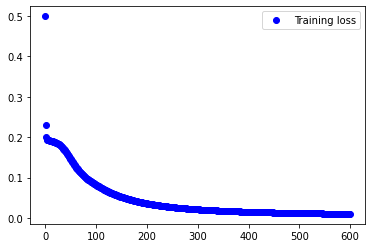

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot Training loss
epoch_range = range(e+1)

plt.plot(epoch_range, avg_train_loss, 'bo', label='Training loss')
plt.legend()
plt.figure()

In [ ]:
# Plot Validation loss

plt.plot(epoch_range, avg_val_loss, 'b', label='Validation loss')
plt.title('Validation loss')
plt.legend()

plt.figure()

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot validation accuracy

plt.plot(epoch_range, validation_accuracy, 'b', label='Validation accuracy')
plt.title('Validation accuracy')
plt.legend()

plt.figure()

In [ ]:
# plot validation F1

plt.plot(epoch_range, validation_f1, 'b', label='Validation F1 score')
plt.title('Validation F1')
plt.legend()

plt.figure()